In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Global parameters
TOTAL_STUDENTS = 10000
GROUP1_FRACTION = 0.7
GROUP2_FRACTION = 0.3
PREFER_A_GROUP1 = 0.6
PREFER_A_GROUP2 = 0.6
CAPACITY_A = 4000
CAPACITY_B = 3000

# Correlation coefficients for the bivariate normal distributions
CORRELATION_GROUP1 = 0.8  # Higher correlation for group 1
CORRELATION_GROUP2 = 0.2  # Lower correlation for group 2

# Mean and standard deviation for the score distributions
SCORE_MEAN = 70
SCORE_STD = 15

In [ ]:
def generate_students():
    """Generate the student population with group assignments and preferences"""
    students = pd.DataFrame({
        'student_id': range(TOTAL_STUDENTS),
        'group': np.random.choice([1, 2],
                                 size=TOTAL_STUDENTS,
                                 p=[GROUP1_FRACTION, GROUP2_FRACTION])
    })

    # Assign preferences based on group
    students['preference'] = students.apply(
        lambda row: np.random.choice(['A', 'B'],
                                    p=[PREFER_A_GROUP1, 1-PREFER_A_GROUP1] if row['group'] == 1
                                    else [PREFER_A_GROUP2, 1-PREFER_A_GROUP2]),
        axis=1
    )

    # Set second preference (if first is A, then second is B and vice versa)
    students['second_preference'] = students['preference'].apply(lambda x: 'B' if x == 'A' else 'A')

    return students

# Generate students
students = generate_students()

# Display summary statistics
print(f"Total students: {TOTAL_STUDENTS}")
print(f"Group 1 students: {sum(students['group'] == 1)}")
print(f"Group 2 students: {sum(students['group'] == 2)}")
print(f"Students preferring A: {sum(students['preference'] == 'A')}")
print(f"Students preferring B: {sum(students['preference'] == 'B')}")

# Add detailed breakdown of preferences by group
group1_prefer_A = sum((students['group'] == 1) & (students['preference'] == 'A'))
group1_prefer_B = sum((students['group'] == 1) & (students['preference'] == 'B'))
group2_prefer_A = sum((students['group'] == 2) & (students['preference'] == 'A'))
group2_prefer_B = sum((students['group'] == 2) & (students['preference'] == 'B'))

print("\nPreference breakdown by group:")
print(f"Group 1 students preferring A: {group1_prefer_A} ({group1_prefer_A/sum(students['group'] == 1)*100:.1f}%)")
print(f"Group 1 students preferring B: {group1_prefer_B} ({group1_prefer_B/sum(students['group'] == 1)*100:.1f}%)")
print(f"Group 2 students preferring A: {group2_prefer_A} ({group2_prefer_A/sum(students['group'] == 2)*100:.1f}%)")
print(f"Group 2 students preferring B: {group2_prefer_B} ({group2_prefer_B/sum(students['group'] == 2)*100:.1f}%)")

print("\nSample of student data:")
print(students.head())

Total students: 10000
Group 1 students: 7113
Group 2 students: 2887
Students preferring A: 5945
Students preferring B: 4055

Preference breakdown by group:
Group 1 students preferring A: 4235 (59.5%)
Group 1 students preferring B: 2878 (40.5%)
Group 2 students preferring A: 1710 (59.2%)
Group 2 students preferring B: 1177 (40.8%)

Sample of student data:
   student_id  group preference second_preference
0           0      1          A                 B
1           1      2          A                 B
2           2      2          A                 B
3           3      1          B                 A
4           4      1          A                 B


Summary statistics for scores:
            score_A       score_B
count  10000.000000  10000.000000
mean      69.972724     69.864561
std       14.891585     14.810437
min       12.924254     14.680717
25%       59.773168     59.595551
50%       70.220665     70.041475
75%       80.380609     80.512762
max      100.000000    100.000000


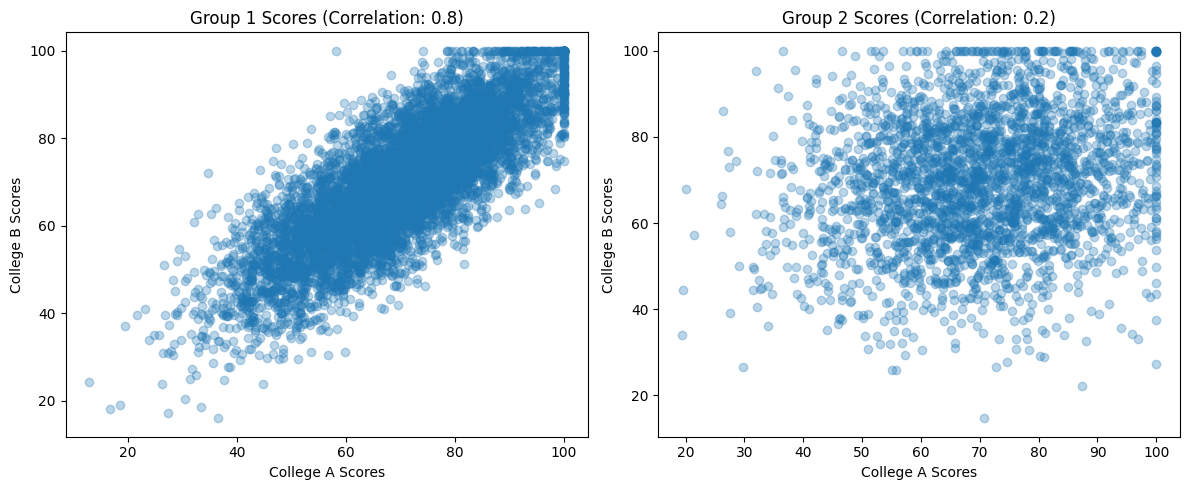

In [ ]:
def generate_scores(students):
    """
    Generate scores for each student from each college using bivariate normal distribution
    with different correlations based on student group
    """
    # Create arrays to store scores
    n_students = len(students)
    scores_A = np.zeros(n_students)
    scores_B = np.zeros(n_students)

    # Generate scores for Group 1 students using bivariate normal with higher correlation
    group1_indices = students.index[students['group'] == 1].tolist()
    n_group1 = len(group1_indices)

    if n_group1 > 0:
        cov_matrix_group1 = np.array([[SCORE_STD**2, CORRELATION_GROUP1 * SCORE_STD**2],
                                      [CORRELATION_GROUP1 * SCORE_STD**2, SCORE_STD**2]])

        group1_scores = np.random.multivariate_normal(
            mean=[SCORE_MEAN, SCORE_MEAN],
            cov=cov_matrix_group1,
            size=n_group1
        )
        scores_A[group1_indices] = group1_scores[:, 0]
        scores_B[group1_indices] = group1_scores[:, 1]

    # Generate scores for Group 2 students using bivariate normal with lower correlation
    group2_indices = students.index[students['group'] == 2].tolist()
    n_group2 = len(group2_indices)

    if n_group2 > 0:
        cov_matrix_group2 = np.array([[SCORE_STD**2, CORRELATION_GROUP2 * SCORE_STD**2],
                                      [CORRELATION_GROUP2 * SCORE_STD**2, SCORE_STD**2]])

        group2_scores = np.random.multivariate_normal(
            mean=[SCORE_MEAN, SCORE_MEAN],
            cov=cov_matrix_group2,
            size=n_group2
        )
        scores_A[group2_indices] = group2_scores[:, 0]
        scores_B[group2_indices] = group2_scores[:, 1]

    # Add scores to student dataframe
    students['score_A'] = np.clip(scores_A, 0, 100)  # Ensure scores are between 0 and 100
    students['score_B'] = np.clip(scores_B, 0, 100)

    return students

# Generate scores for all students
students = generate_scores(students)

# Display summary of scores
print("Summary statistics for scores:")
print(students[['score_A', 'score_B']].describe())

# Visualize correlation between scores for each group
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
group1 = students[students['group'] == 1]
plt.scatter(group1['score_A'], group1['score_B'], alpha=0.3)
plt.title(f'Group 1 Scores (Correlation: {CORRELATION_GROUP1})')
plt.xlabel('College A Scores')
plt.ylabel('College B Scores')

plt.subplot(1, 2, 2)
group2 = students[students['group'] == 2]
plt.scatter(group2['score_A'], group2['score_B'], alpha=0.3)
plt.title(f'Group 2 Scores (Correlation: {CORRELATION_GROUP2})')
plt.xlabel('College A Scores')
plt.ylabel('College B Scores')

plt.tight_layout()
plt.show()

In [ ]:
def run_matching_algorithm(students):
    """
    Implement the two-round matching algorithm:
    1. Students apply to preferred college
    2. Colleges select top students
    3. Rejected students apply to second choice
    4. Colleges select from pool of previously accepted + new applicants
    """
    # Create a copy of students dataframe to track assignments
    students = students.copy()
    students['assigned_to'] = None

    # Round 1: Students apply to preferred colleges
    applicants_A_round1 = students[students['preference'] == 'A'].copy()
    applicants_B_round1 = students[students['preference'] == 'B'].copy()

    # Colleges select top students based on scores
    accepted_A_round1 = applicants_A_round1.sort_values('score_A', ascending=False).head(CAPACITY_A)
    accepted_B_round1 = applicants_B_round1.sort_values('score_B', ascending=False).head(CAPACITY_B)

    # Mark students as accepted by colleges
    students.loc[accepted_A_round1.index, 'assigned_to'] = 'A'
    students.loc[accepted_B_round1.index, 'assigned_to'] = 'B'

    # Round 2: Rejected students apply to their second choice
    rejected_A_round1 = applicants_A_round1[~applicants_A_round1.index.isin(accepted_A_round1.index)]
    rejected_B_round1 = applicants_B_round1[~applicants_B_round1.index.isin(accepted_B_round1.index)]

    # New applicants for round 2
    applicants_A_round2 = rejected_B_round1.copy()  # Students who preferred B but were rejected
    applicants_B_round2 = rejected_A_round1.copy()  # Students who preferred A but were rejected

    # Combine pools: previously accepted + new applicants
    pool_A_round2 = pd.concat([accepted_A_round1, applicants_A_round2])
    pool_B_round2 = pd.concat([accepted_B_round1, applicants_B_round2])

    # Colleges re-select top students from the new pools
    accepted_A_round2 = pool_A_round2.sort_values('score_A', ascending=False).head(CAPACITY_A)
    accepted_B_round2 = pool_B_round2.sort_values('score_B', ascending=False).head(CAPACITY_B)

    # Reset assignments and update with final selection
    students['assigned_to'] = None
    students.loc[accepted_A_round2.index, 'assigned_to'] = 'A'
    students.loc[accepted_B_round2.index, 'assigned_to'] = 'B'

    return students

# Run the matching algorithm
matched_students = run_matching_algorithm(students)

# Display matching statistics
print("Matching Results:")
assignment_counts = matched_students['assigned_to'].value_counts(dropna=True)
unassigned = matched_students['assigned_to'].isna().sum()

print(f"Assigned to College A: {assignment_counts.get('A', 0)} students")
print(f"Assigned to College B: {assignment_counts.get('B', 0)} students")
print(f"Unassigned: {unassigned} students")

Matching Results:
Assigned to College A: 4000 students
Assigned to College B: 3000 students
Unassigned: 3000 students


In [ ]:
def calculate_welfare_metrics(matched_students):
    """
    Calculate various welfare metrics for the assignment

    Returns:
        dict: Dictionary containing all welfare metrics
    """
    metrics = {}

    # Helper function to calculate metrics
    def calculate_metric(group, prefer, assigned):
        # Filter students by group and preference
        if prefer == 'A':
            students_group_prefer = matched_students[(matched_students['group'] == group) &
                                                    (matched_students['preference'] == 'A')]
        else:
            students_group_prefer = matched_students[(matched_students['group'] == group) &
                                                    (matched_students['preference'] == 'B')]

        # Total number in this group with this preference
        total = len(students_group_prefer)

        if total == 0:
            return 0.0  # Avoid division by zero

        # Calculate based on assignment
        if assigned == 'first':
            # Got their first preference
            count = len(students_group_prefer[students_group_prefer['assigned_to'] == students_group_prefer['preference']])
        elif assigned == 'second':
            # Got their second preference
            count = len(students_group_prefer[students_group_prefer['assigned_to'] == students_group_prefer['second_preference']])
        elif assigned == 'none':
            # Got no assignment
            count = len(students_group_prefer[students_group_prefer['assigned_to'].isna()])

        return count / total

    # Calculate V_first metrics
    metrics['V_first(G1,A)'] = calculate_metric(1, 'A', 'first')
    metrics['V_first(G1,B)'] = calculate_metric(1, 'B', 'first')
    metrics['V_first(G2,A)'] = calculate_metric(2, 'A', 'first')
    metrics['V_first(G2,B)'] = calculate_metric(2, 'B', 'first')

    # Calculate V_second metrics
    metrics['V_second(G1,A)'] = calculate_metric(1, 'A', 'second')
    metrics['V_second(G1,B)'] = calculate_metric(1, 'B', 'second')
    metrics['V_second(G2,A)'] = calculate_metric(2, 'A', 'second')
    metrics['V_second(G2,B)'] = calculate_metric(2, 'B', 'second')

    # Calculate V_none metrics
    metrics['V_none(G1,A)'] = calculate_metric(1, 'A', 'none')
    metrics['V_none(G1,B)'] = calculate_metric(1, 'B', 'none')
    metrics['V_none(G2,A)'] = calculate_metric(2, 'A', 'none')
    metrics['V_none(G2,B)'] = calculate_metric(2, 'B', 'none')

    return metrics

# Calculate welfare metrics
welfare_metrics = calculate_welfare_metrics(matched_students)

In [ ]:
def print_welfare_metrics(metrics):
    """
    Print the welfare metrics in a formatted table

    Args:
        metrics (dict): Dictionary containing welfare metrics
    """
    print("\n===== WELFARE METRICS =====\n")

    # Print header
    print("Metric               | Value")
    print("---------------------|-------")

    # Print each metric with formatting
    for key, value in metrics.items():
        print(f"{key:<21} | {value:.4f} ({value*100:.1f}%)")

    # Print grouped summary
    print("\n--- Summary by Group and Preference ---\n")

    # Group 1, Prefer A
    print("Group 1 students who prefer A:")
    print(f"  - Received first choice (A): {metrics['V_first(G1,A)']:.4f} ({metrics['V_first(G1,A)']*100:.1f}%)")
    print(f"  - Received second choice (B): {metrics['V_second(G1,A)']:.4f} ({metrics['V_second(G1,A)']*100:.1f}%)")
    print(f"  - Remained unassigned: {metrics['V_none(G1,A)']:.4f} ({metrics['V_none(G1,A)']*100:.1f}%)")
    print(f"  - Total: {metrics['V_first(G1,A)'] + metrics['V_second(G1,A)'] + metrics['V_none(G1,A)']:.4f}\n")

    # Group 1, Prefer B
    print("Group 1 students who prefer B:")
    print(f"  - Received first choice (B): {metrics['V_first(G1,B)']:.4f} ({metrics['V_first(G1,B)']*100:.1f}%)")
    print(f"  - Received second choice (A): {metrics['V_second(G1,B)']:.4f} ({metrics['V_second(G1,B)']*100:.1f}%)")
    print(f"  - Remained unassigned: {metrics['V_none(G1,B)']:.4f} ({metrics['V_none(G1,B)']*100:.1f}%)")
    print(f"  - Total: {metrics['V_first(G1,B)'] + metrics['V_second(G1,B)'] + metrics['V_none(G1,B)']:.4f}\n")

    # Group 2, Prefer A
    print("Group 2 students who prefer A:")
    print(f"  - Received first choice (A): {metrics['V_first(G2,A)']:.4f} ({metrics['V_first(G2,A)']*100:.1f}%)")
    print(f"  - Received second choice (B): {metrics['V_second(G2,A)']:.4f} ({metrics['V_second(G2,A)']*100:.1f}%)")
    print(f"  - Remained unassigned: {metrics['V_none(G2,A)']:.4f} ({metrics['V_none(G2,A)']*100:.1f}%)")
    print(f"  - Total: {metrics['V_first(G2,A)'] + metrics['V_second(G2,A)'] + metrics['V_none(G2,A)']:.4f}\n")

    # Group 2, Prefer B
    print("Group 2 students who prefer B:")
    print(f"  - Received first choice (B): {metrics['V_first(G2,B)']:.4f} ({metrics['V_first(G2,B)']*100:.1f}%)")
    print(f"  - Received second choice (A): {metrics['V_second(G2,B)']:.4f} ({metrics['V_second(G2,B)']*100:.1f}%)")
    print(f"  - Remained unassigned: {metrics['V_none(G2,B)']:.4f} ({metrics['V_none(G2,B)']*100:.1f}%)")
    print(f"  - Total: {metrics['V_first(G2,B)'] + metrics['V_second(G2,B)'] + metrics['V_none(G2,B)']:.4f}\n")

    # Print overall group statistics
    print("--- Overall Group Statistics ---\n")

    g1_first = (metrics['V_first(G1,A)'] * len(matched_students[(matched_students['group'] == 1) &
                                              (matched_students['preference'] == 'A')]) +
                metrics['V_first(G1,B)'] * len(matched_students[(matched_students['group'] == 1) &
                                              (matched_students['preference'] == 'B')])) / \
               len(matched_students[matched_students['group'] == 1])

    g2_first = (metrics['V_first(G2,A)'] * len(matched_students[(matched_students['group'] == 2) &
                                              (matched_students['preference'] == 'A')]) +
                metrics['V_first(G2,B)'] * len(matched_students[(matched_students['group'] == 2) &
                                              (matched_students['preference'] == 'B')])) / \
               len(matched_students[matched_students['group'] == 2])

    print(f"Group 1 overall first preference satisfaction: {g1_first:.4f} ({g1_first*100:.1f}%)")
    print(f"Group 2 overall first preference satisfaction: {g2_first:.4f} ({g2_first*100:.1f}%)")

    # Calculate disparity
    disparity = abs(g1_first - g2_first)
    print(f"\nDisparity between groups (absolute difference): {disparity:.4f} ({disparity*100:.1f}%)")

# Print the welfare metrics
print_welfare_metrics(welfare_metrics)


===== WELFARE METRICS =====

Metric               | Value
---------------------|-------
V_first(G1,A)         | 0.6198 (62.0%)
V_first(G1,B)         | 0.5980 (59.8%)
V_first(G2,A)         | 0.6380 (63.8%)
V_first(G2,B)         | 0.6321 (63.2%)
V_second(G1,A)        | 0.0621 (6.2%)
V_second(G1,B)        | 0.0413 (4.1%)
V_second(G2,A)        | 0.1591 (15.9%)
V_second(G2,B)        | 0.1402 (14.0%)
V_none(G1,A)          | 0.3181 (31.8%)
V_none(G1,B)          | 0.3607 (36.1%)
V_none(G2,A)          | 0.2029 (20.3%)
V_none(G2,B)          | 0.2277 (22.8%)

--- Summary by Group and Preference ---

Group 1 students who prefer A:
  - Received first choice (A): 0.6198 (62.0%)
  - Received second choice (B): 0.0621 (6.2%)
  - Remained unassigned: 0.3181 (31.8%)
  - Total: 1.0000

Group 1 students who prefer B:
  - Received first choice (B): 0.5980 (59.8%)
  - Received second choice (A): 0.0413 (4.1%)
  - Remained unassigned: 0.3607 (36.1%)
  - Total: 1.0000

Group 2 students who prefer A:
  - Rece

# The real comparative experiment

In [ ]:
# Define parameter ranges
# Using np.linspace to create evenly distributed values within ranges
GROUP1_FRACTIONS = np.linspace(0.15, 0.85, 5)  # 5 values between 0.15 and 0.85
PREFER_A_GROUP1_VALUES = np.linspace(0.15, 0.85, 5)
PREFER_A_GROUP2_VALUES = np.linspace(0.15, 0.85, 5)
CORRELATION_GROUP1_VALUES = np.linspace(0.1, 0.5, 5)  # Lower range for Group 1
CORRELATION_GROUP2_VALUES = np.linspace(0.6, 0.9, 5)  # Higher range for Group 2

# Constants that remain the same
TOTAL_STUDENTS = 10000
CAPACITY_A = 4000
CAPACITY_B = 3000
SCORE_MEAN = 70
SCORE_STD = 15

# Create a DataFrame to store all results
results = pd.DataFrame(columns=[
    'GROUP1_FRACTION', 'GROUP2_FRACTION',
    'PREFER_A_GROUP1', 'PREFER_A_GROUP2',
    'CORRELATION_GROUP1', 'CORRELATION_GROUP2',
    'V_first(G1,A)', 'V_first(G1,B)', 'V_first(G2,A)', 'V_first(G2,B)',
    'V_second(G1,A)', 'V_second(G1,B)', 'V_second(G2,A)', 'V_second(G2,B)',
    'V_none(G1,A)', 'V_none(G1,B)', 'V_none(G2,A)', 'V_none(G2,B)'
])

# Progress tracking
total_iterations = len(GROUP1_FRACTIONS) * len(PREFER_A_GROUP1_VALUES) * len(PREFER_A_GROUP2_VALUES) * len(CORRELATION_GROUP1_VALUES) * len(CORRELATION_GROUP2_VALUES)
current_iteration = 0

print(f"Starting experiment with {total_iterations} parameter combinations...")
print(f"GROUP1_FRACTIONS: {GROUP1_FRACTIONS}")
print(f"PREFER_A_GROUP1_VALUES: {PREFER_A_GROUP1_VALUES}")
print(f"PREFER_A_GROUP2_VALUES: {PREFER_A_GROUP2_VALUES}")
print(f"CORRELATION_GROUP1_VALUES: {CORRELATION_GROUP1_VALUES}")
print(f"CORRELATION_GROUP2_VALUES: {CORRELATION_GROUP2_VALUES}")

Starting experiment with 3125 parameter combinations...
GROUP1_FRACTIONS: [0.15  0.325 0.5   0.675 0.85 ]
PREFER_A_GROUP1_VALUES: [0.15  0.325 0.5   0.675 0.85 ]
PREFER_A_GROUP2_VALUES: [0.15  0.325 0.5   0.675 0.85 ]
CORRELATION_GROUP1_VALUES: [0.1 0.2 0.3 0.4 0.5]
CORRELATION_GROUP2_VALUES: [0.6   0.675 0.75  0.825 0.9  ]


In [ ]:
# Run the experiment for all parameter combinations
for GROUP1_FRACTION in GROUP1_FRACTIONS:
    GROUP2_FRACTION = 1 - GROUP1_FRACTION

    for PREFER_A_GROUP1 in PREFER_A_GROUP1_VALUES:
        for PREFER_A_GROUP2 in PREFER_A_GROUP2_VALUES:
            for CORRELATION_GROUP1 in CORRELATION_GROUP1_VALUES:
                for CORRELATION_GROUP2 in CORRELATION_GROUP2_VALUES:
                    # Set random seeds for reproducibility
                    np.random.seed(42)
                    random.seed(42)

                    # Generate students
                    students = pd.DataFrame({
                        'student_id': range(TOTAL_STUDENTS),
                        'group': np.random.choice([1, 2],
                                                size=TOTAL_STUDENTS,
                                                p=[GROUP1_FRACTION, GROUP2_FRACTION])
                    })

                    # Assign preferences based on group
                    students['preference'] = students.apply(
                        lambda row: np.random.choice(['A', 'B'],
                                                   p=[PREFER_A_GROUP1, 1-PREFER_A_GROUP1] if row['group'] == 1
                                                   else [PREFER_A_GROUP2, 1-PREFER_A_GROUP2]),
                        axis=1
                    )

                    # Set second preference
                    students['second_preference'] = students['preference'].apply(lambda x: 'B' if x == 'A' else 'A')

                    # Generate scores
                    n_students = len(students)
                    scores_A = np.zeros(n_students)
                    scores_B = np.zeros(n_students)

                    # Generate scores for Group 1 students
                    group1_indices = students.index[students['group'] == 1].tolist()
                    n_group1 = len(group1_indices)

                    if n_group1 > 0:
                        cov_matrix_group1 = np.array([[SCORE_STD**2, CORRELATION_GROUP1 * SCORE_STD**2],
                                                     [CORRELATION_GROUP1 * SCORE_STD**2, SCORE_STD**2]])

                        group1_scores = np.random.multivariate_normal(
                            mean=[SCORE_MEAN, SCORE_MEAN],
                            cov=cov_matrix_group1,
                            size=n_group1
                        )
                        scores_A[group1_indices] = group1_scores[:, 0]
                        scores_B[group1_indices] = group1_scores[:, 1]

                    # Generate scores for Group 2 students
                    group2_indices = students.index[students['group'] == 2].tolist()
                    n_group2 = len(group2_indices)

                    if n_group2 > 0:
                        cov_matrix_group2 = np.array([[SCORE_STD**2, CORRELATION_GROUP2 * SCORE_STD**2],
                                                     [CORRELATION_GROUP2 * SCORE_STD**2, SCORE_STD**2]])

                        group2_scores = np.random.multivariate_normal(
                            mean=[SCORE_MEAN, SCORE_MEAN],
                            cov=cov_matrix_group2,
                            size=n_group2
                        )
                        scores_A[group2_indices] = group2_scores[:, 0]
                        scores_B[group2_indices] = group2_scores[:, 1]

                    # Add scores to student dataframe
                    students['score_A'] = np.clip(scores_A, 0, 100)
                    students['score_B'] = np.clip(scores_B, 0, 100)

                    # Run the matching algorithm
                    matched_students = students.copy()
                    matched_students['assigned_to'] = None

                    # Round 1: Students apply to preferred colleges
                    applicants_A_round1 = matched_students[matched_students['preference'] == 'A'].copy()
                    applicants_B_round1 = matched_students[matched_students['preference'] == 'B'].copy()

                    # Colleges select top students based on scores
                    accepted_A_round1 = applicants_A_round1.sort_values('score_A', ascending=False).head(CAPACITY_A)
                    accepted_B_round1 = applicants_B_round1.sort_values('score_B', ascending=False).head(CAPACITY_B)

                    # Mark students as accepted by colleges
                    matched_students.loc[accepted_A_round1.index, 'assigned_to'] = 'A'
                    matched_students.loc[accepted_B_round1.index, 'assigned_to'] = 'B'

                    # Round 2: Rejected students apply to their second choice
                    rejected_A_round1 = applicants_A_round1[~applicants_A_round1.index.isin(accepted_A_round1.index)]
                    rejected_B_round1 = applicants_B_round1[~applicants_B_round1.index.isin(accepted_B_round1.index)]

                    # New applicants for round 2
                    applicants_A_round2 = rejected_B_round1.copy()
                    applicants_B_round2 = rejected_A_round1.copy()

                    # Combine pools: previously accepted + new applicants
                    pool_A_round2 = pd.concat([accepted_A_round1, applicants_A_round2])
                    pool_B_round2 = pd.concat([accepted_B_round1, applicants_B_round2])

                    # Colleges re-select top students from the new pools
                    accepted_A_round2 = pool_A_round2.sort_values('score_A', ascending=False).head(CAPACITY_A)
                    accepted_B_round2 = pool_B_round2.sort_values('score_B', ascending=False).head(CAPACITY_B)

                    # Reset assignments and update with final selection
                    matched_students['assigned_to'] = None
                    matched_students.loc[accepted_A_round2.index, 'assigned_to'] = 'A'
                    matched_students.loc[accepted_B_round2.index, 'assigned_to'] = 'B'

                    # Calculate welfare metrics
                    metrics = {}

                    # Helper function to calculate metrics
                    def calculate_metric(group, prefer, assigned):
                        students_group_prefer = matched_students[(matched_students['group'] == group) &
                                                              (matched_students['preference'] == prefer)]

                        total = len(students_group_prefer)

                        if total == 0:
                            return 0.0

                        if assigned == 'first':
                            count = len(students_group_prefer[students_group_prefer['assigned_to'] == prefer])
                        elif assigned == 'second':
                            second_pref = 'B' if prefer == 'A' else 'A'
                            count = len(students_group_prefer[students_group_prefer['assigned_to'] == second_pref])
                        elif assigned == 'none':
                            count = len(students_group_prefer[students_group_prefer['assigned_to'].isna()])

                        return count / total

                    # Calculate all welfare metrics
                    metrics['V_first(G1,A)'] = calculate_metric(1, 'A', 'first')
                    metrics['V_first(G1,B)'] = calculate_metric(1, 'B', 'first')
                    metrics['V_first(G2,A)'] = calculate_metric(2, 'A', 'first')
                    metrics['V_first(G2,B)'] = calculate_metric(2, 'B', 'first')

                    metrics['V_second(G1,A)'] = calculate_metric(1, 'A', 'second')
                    metrics['V_second(G1,B)'] = calculate_metric(1, 'B', 'second')
                    metrics['V_second(G2,A)'] = calculate_metric(2, 'A', 'second')
                    metrics['V_second(G2,B)'] = calculate_metric(2, 'B', 'second')

                    metrics['V_none(G1,A)'] = calculate_metric(1, 'A', 'none')
                    metrics['V_none(G1,B)'] = calculate_metric(1, 'B', 'none')
                    metrics['V_none(G2,A)'] = calculate_metric(2, 'A', 'none')
                    metrics['V_none(G2,B)'] = calculate_metric(2, 'B', 'none')

                    # Store results
                    results.loc[len(results)] = {
                        'GROUP1_FRACTION': GROUP1_FRACTION,
                        'GROUP2_FRACTION': GROUP2_FRACTION,
                        'PREFER_A_GROUP1': PREFER_A_GROUP1,
                        'PREFER_A_GROUP2': PREFER_A_GROUP2,
                        'CORRELATION_GROUP1': CORRELATION_GROUP1,
                        'CORRELATION_GROUP2': CORRELATION_GROUP2,
                        **metrics
                    }

                    # Update progress
                    current_iteration += 1
                    if current_iteration % 25 == 0 or current_iteration == total_iterations:
                        print(f"Completed iteration {current_iteration}/{total_iterations} ({current_iteration/total_iterations*100:.1f}%)")

print("Experiment completed!")
print(f"Collected data for {len(results)} parameter combinations")
print("\nSummary statistics for welfare metrics:")
print(results[['V_first(G1,A)', 'V_first(G2,A)', 'V_first(G1,B)', 'V_first(G2,B)',
               'V_second(G1,A)', 'V_second(G2,A)', 'V_second(G1,B)', 'V_second(G2,B)',
               'V_none(G1,A)', 'V_none(G2,A)', 'V_none(G1,B)', 'V_none(G2,B)']].describe())

Completed iteration 25/3125 (0.8%)
Completed iteration 50/3125 (1.6%)
Completed iteration 75/3125 (2.4%)
Completed iteration 100/3125 (3.2%)
Completed iteration 125/3125 (4.0%)
Completed iteration 150/3125 (4.8%)
Completed iteration 175/3125 (5.6%)
Completed iteration 200/3125 (6.4%)
Completed iteration 225/3125 (7.2%)
Completed iteration 250/3125 (8.0%)
Completed iteration 275/3125 (8.8%)
Completed iteration 300/3125 (9.6%)
Completed iteration 325/3125 (10.4%)
Completed iteration 350/3125 (11.2%)
Completed iteration 375/3125 (12.0%)
Completed iteration 400/3125 (12.8%)
Completed iteration 425/3125 (13.6%)
Completed iteration 450/3125 (14.4%)
Completed iteration 475/3125 (15.2%)
Completed iteration 500/3125 (16.0%)
Completed iteration 525/3125 (16.8%)
Completed iteration 550/3125 (17.6%)
Completed iteration 575/3125 (18.4%)
Completed iteration 600/3125 (19.2%)
Completed iteration 625/3125 (20.0%)
Completed iteration 650/3125 (20.8%)
Completed iteration 675/3125 (21.6%)
Completed iterat

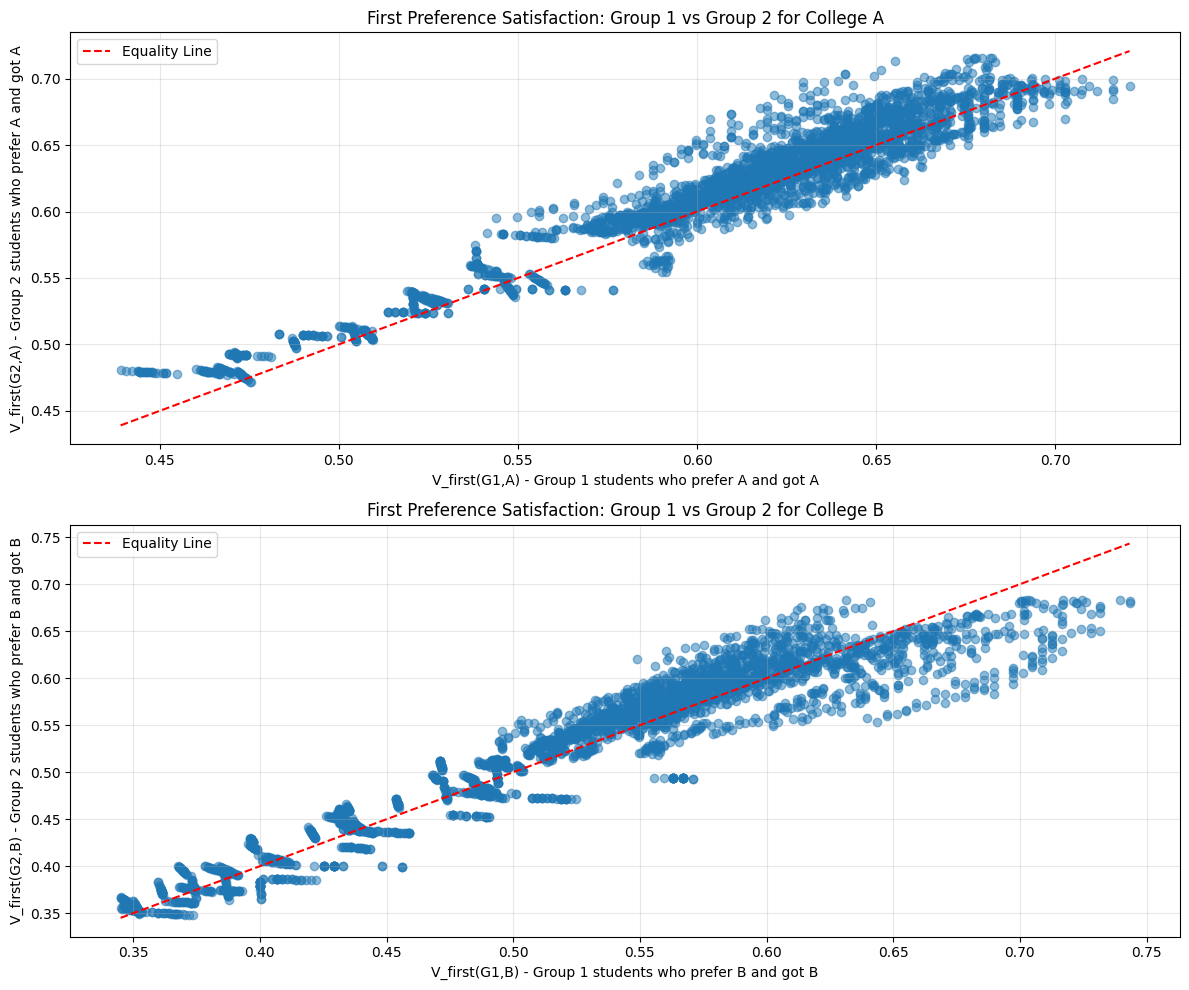

In [ ]:
# Plot V_first(G1,A) vs V_first(G2,A)
plt.figure(figsize=(12, 10))

# Plot 1: V_first(G1,A) vs V_first(G2,A)
plt.subplot(2, 1, 1)
plt.scatter(results['V_first(G1,A)'], results['V_first(G2,A)'], alpha=0.5)
plt.title('First Preference Satisfaction: Group 1 vs Group 2 for College A')
plt.xlabel('V_first(G1,A) - Group 1 students who prefer A and got A')
plt.ylabel('V_first(G2,A) - Group 2 students who prefer A and got A')

# Add 45-degree line
min_val = min(results['V_first(G1,A)'].min(), results['V_first(G2,A)'].min())
max_val = max(results['V_first(G1,A)'].max(), results['V_first(G2,A)'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Equality Line')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: V_first(G1,B) vs V_first(G2,B)
plt.subplot(2, 1, 2)
plt.scatter(results['V_first(G1,B)'], results['V_first(G2,B)'], alpha=0.5)
plt.title('First Preference Satisfaction: Group 1 vs Group 2 for College B')
plt.xlabel('V_first(G1,B) - Group 1 students who prefer B and got B')
plt.ylabel('V_first(G2,B) - Group 2 students who prefer B and got B')

# Add 45-degree line
min_val = min(results['V_first(G1,B)'].min(), results['V_first(G2,B)'].min())
max_val = max(results['V_first(G1,B)'].max(), results['V_first(G2,B)'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Equality Line')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('V_first_comparison.png')  # Save the plot
plt.show()

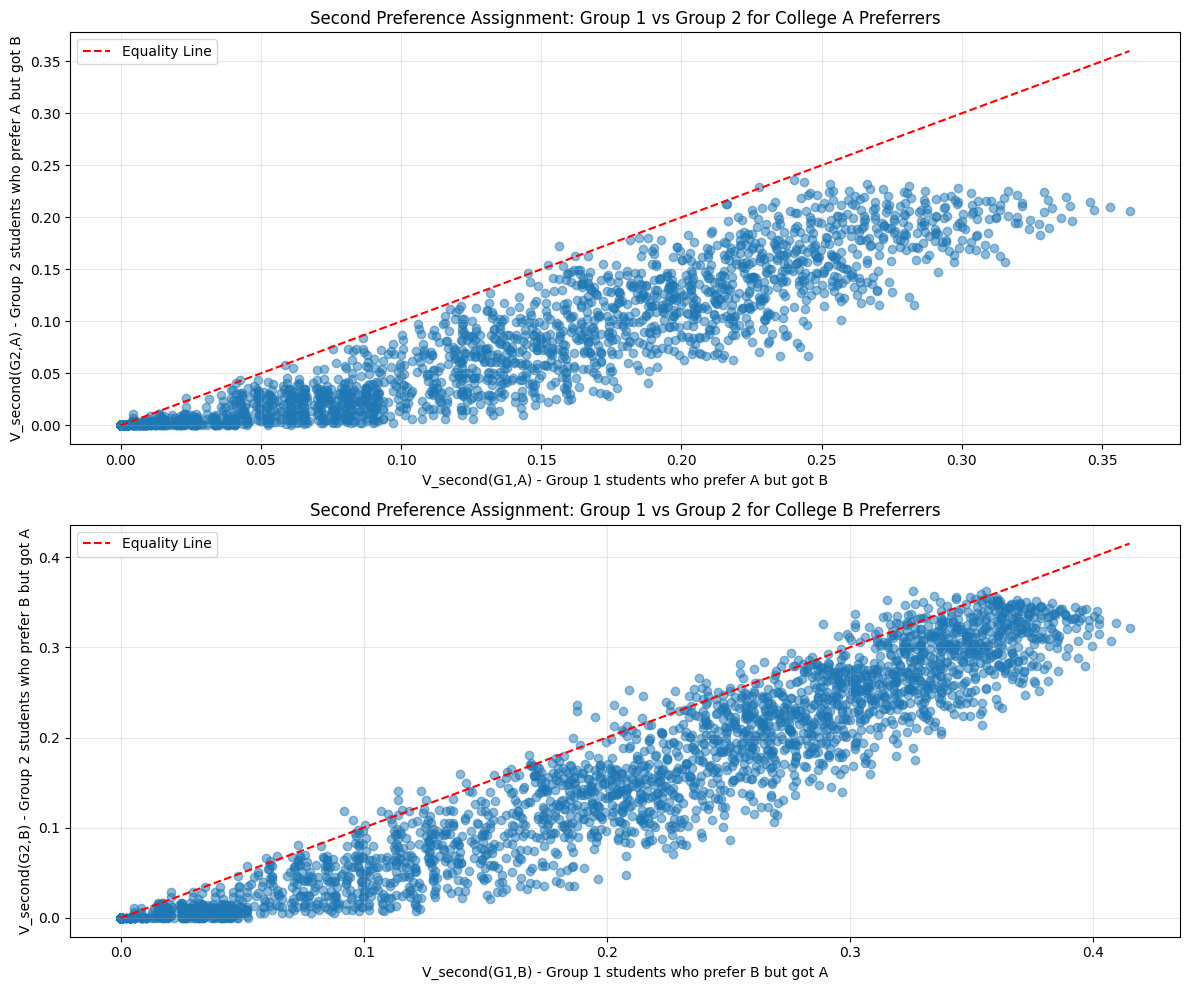

In [ ]:
# Plot V_second comparisons
plt.figure(figsize=(12, 10))

# Plot 1: V_second(G1,A) vs V_second(G2,A)
plt.subplot(2, 1, 1)
plt.scatter(results['V_second(G1,A)'], results['V_second(G2,A)'], alpha=0.5)
plt.title('Second Preference Assignment: Group 1 vs Group 2 for College A Preferrers')
plt.xlabel('V_second(G1,A) - Group 1 students who prefer A but got B')
plt.ylabel('V_second(G2,A) - Group 2 students who prefer A but got B')

# Add 45-degree line
min_val = min(results['V_second(G1,A)'].min(), results['V_second(G2,A)'].min())
max_val = max(results['V_second(G1,A)'].max(), results['V_second(G2,A)'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Equality Line')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: V_second(G1,B) vs V_second(G2,B)
plt.subplot(2, 1, 2)
plt.scatter(results['V_second(G1,B)'], results['V_second(G2,B)'], alpha=0.5)
plt.title('Second Preference Assignment: Group 1 vs Group 2 for College B Preferrers')
plt.xlabel('V_second(G1,B) - Group 1 students who prefer B but got A')
plt.ylabel('V_second(G2,B) - Group 2 students who prefer B but got A')

# Add 45-degree line
min_val = min(results['V_second(G1,B)'].min(), results['V_second(G2,B)'].min())
max_val = max(results['V_second(G1,B)'].max(), results['V_second(G2,B)'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Equality Line')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('V_second_comparison.png')  # Save the plot
plt.show()

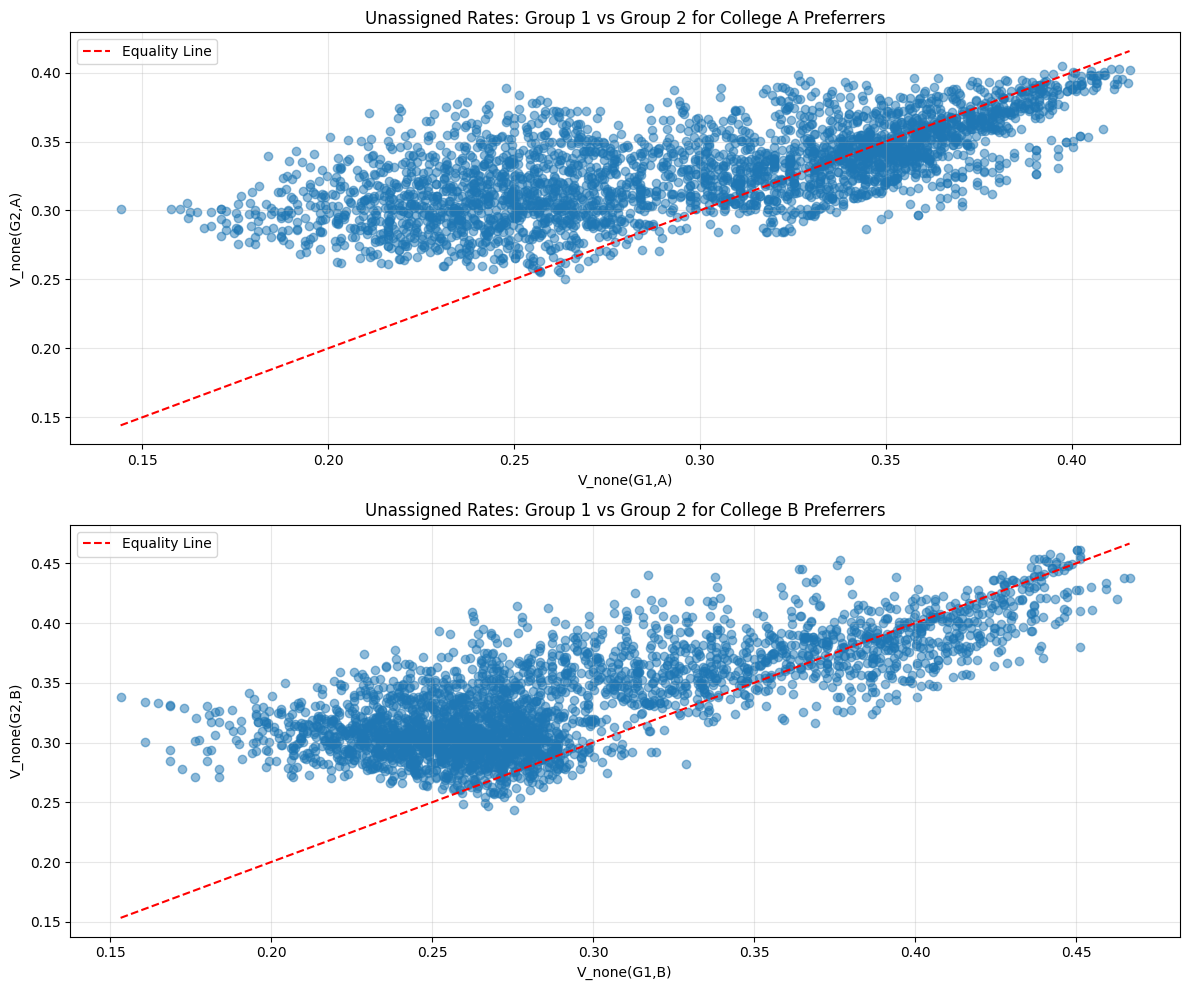

In [ ]:
# Plot V_none comparisons
plt.figure(figsize=(12, 10))

# Plot 1: V_none(G1,A) vs V_none(G2,A)
plt.subplot(2, 1, 1)
plt.scatter(results['V_none(G1,A)'], results['V_none(G2,A)'], alpha=0.5)
plt.title('Unassigned Rates: Group 1 vs Group 2 for College A Preferrers')
plt.xlabel('V_none(G1,A)')
plt.ylabel('V_none(G2,A)')

# Add 45-degree line
min_val = min(results['V_none(G1,A)'].min(), results['V_none(G2,A)'].min())
max_val = max(results['V_none(G1,A)'].max(), results['V_none(G2,A)'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Equality Line')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: V_none(G1,B) vs V_none(G2,B)
plt.subplot(2, 1, 2)
plt.scatter(results['V_none(G1,B)'], results['V_none(G2,B)'], alpha=0.5)
plt.title('Unassigned Rates: Group 1 vs Group 2 for College B Preferrers')
plt.xlabel('V_none(G1,B)')
plt.ylabel('V_none(G2,B)')

# Add 45-degree line
min_val = min(results['V_none(G1,B)'].min(), results['V_none(G2,B)'].min())
max_val = max(results['V_none(G1,B)'].max(), results['V_none(G2,B)'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Equality Line')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('V_none_comparison.png')  # Save the plot
plt.show()

# Effect of change of correlation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import random

# Fixed parameters
TOTAL_STUDENTS = 10000
GROUP1_FRACTION = 0.6
GROUP2_FRACTION = 0.4
PREFER_A_GROUP1 = 0.6
PREFER_A_GROUP2 = 0.6
CAPACITY_A = 4000
CAPACITY_B = 3000
SCORE_MEAN = 70
SCORE_STD = 15

# Create correlation value ranges - we'll use 20 values to keep runtime manageable
CORRELATION_VALUES = np.linspace(0.1, 0.9, 20)

# Number of trials per parameter set
NUM_TRIALS = 50  # Adjust based on your computation resources

# Create DataFrames to store results with statistics
results_fixed_g1 = pd.DataFrame(columns=[
    'CORRELATION_GROUP1', 'CORRELATION_GROUP2',
    'V_first(G1,A)_mean', 'V_first(G1,B)_mean', 'V_first(G2,A)_mean', 'V_first(G2,B)_mean',
    'V_second(G1,A)_mean', 'V_second(G1,B)_mean', 'V_second(G2,A)_mean', 'V_second(G2,B)_mean',
    'V_none(G1,A)_mean', 'V_none(G1,B)_mean', 'V_none(G2,A)_mean', 'V_none(G2,B)_mean',
    'V_first(G1,A)_se', 'V_first(G1,B)_se', 'V_first(G2,A)_se', 'V_first(G2,B)_se',
    'V_second(G1,A)_se', 'V_second(G1,B)_se', 'V_second(G2,A)_se', 'V_second(G2,B)_se',
    'V_none(G1,A)_se', 'V_none(G1,B)_se', 'V_none(G2,A)_se', 'V_none(G2,B)_se'
])

results_fixed_g2 = pd.DataFrame(columns=results_fixed_g1.columns)

print("Starting correlation experiments with multiple trials...")
print(f"Fixed parameters: TOTAL_STUDENTS={TOTAL_STUDENTS}, GROUP1_FRACTION={GROUP1_FRACTION}, "
      f"PREFER_A_GROUP1={PREFER_A_GROUP1}, PREFER_A_GROUP2={PREFER_A_GROUP2}")
print(f"Number of trials per parameter setting: {NUM_TRIALS}")
print(f"Correlation values: {CORRELATION_VALUES[0]} to {CORRELATION_VALUES[-1]} ({len(CORRELATION_VALUES)} values)")

Starting correlation experiments with multiple trials...
Fixed parameters: TOTAL_STUDENTS=10000, GROUP1_FRACTION=0.6, PREFER_A_GROUP1=0.6, PREFER_A_GROUP2=0.6
Number of trials per parameter setting: 50
Correlation values: 0.1 to 0.9 (20 values)


In [ ]:
def generate_students():
    """Generate student population with fixed demographics"""
    students = pd.DataFrame({
        'student_id': range(TOTAL_STUDENTS),
        'group': np.random.choice([1, 2],
                                 size=TOTAL_STUDENTS,
                                 p=[GROUP1_FRACTION, GROUP2_FRACTION])
    })

    # Assign preferences based on group
    students['preference'] = students.apply(
        lambda row: np.random.choice(['A', 'B'],
                                   p=[PREFER_A_GROUP1, 1-PREFER_A_GROUP1] if row['group'] == 1
                                   else [PREFER_A_GROUP2, 1-PREFER_A_GROUP2]),
        axis=1
    )

    # Set second preference
    students['second_preference'] = students['preference'].apply(lambda x: 'B' if x == 'A' else 'A')

    return students

def generate_scores(students, corr_g1, corr_g2):
    """Generate scores for each student using the specified correlations"""
    n_students = len(students)
    scores_A = np.zeros(n_students)
    scores_B = np.zeros(n_students)

    # Generate scores for Group 1 students
    group1_indices = students.index[students['group'] == 1].tolist()
    n_group1 = len(group1_indices)

    if n_group1 > 0:
        cov_matrix_group1 = np.array([[SCORE_STD**2, corr_g1 * SCORE_STD**2],
                                     [corr_g1 * SCORE_STD**2, SCORE_STD**2]])

        group1_scores = np.random.multivariate_normal(
            mean=[SCORE_MEAN, SCORE_MEAN],
            cov=cov_matrix_group1,
            size=n_group1
        )
        scores_A[group1_indices] = group1_scores[:, 0]
        scores_B[group1_indices] = group1_scores[:, 1]

    # Generate scores for Group 2 students
    group2_indices = students.index[students['group'] == 2].tolist()
    n_group2 = len(group2_indices)

    if n_group2 > 0:
        cov_matrix_group2 = np.array([[SCORE_STD**2, corr_g2 * SCORE_STD**2],
                                     [corr_g2 * SCORE_STD**2, SCORE_STD**2]])

        group2_scores = np.random.multivariate_normal(
            mean=[SCORE_MEAN, SCORE_MEAN],
            cov=cov_matrix_group2,
            size=n_group2
        )
        scores_A[group2_indices] = group2_scores[:, 0]
        scores_B[group2_indices] = group2_scores[:, 1]

    # Add scores to student dataframe
    students['score_A'] = np.clip(scores_A, 0, 100)
    students['score_B'] = np.clip(scores_B, 0, 100)

    return students

def run_matching_algorithm(students):
    """Run the two-round matching algorithm"""
    matched_students = students.copy()
    matched_students['assigned_to'] = None

    # Round 1: Students apply to preferred colleges
    applicants_A_round1 = matched_students[matched_students['preference'] == 'A'].copy()
    applicants_B_round1 = matched_students[matched_students['preference'] == 'B'].copy()

    # Colleges select top students based on scores
    accepted_A_round1 = applicants_A_round1.sort_values('score_A', ascending=False).head(CAPACITY_A)
    accepted_B_round1 = applicants_B_round1.sort_values('score_B', ascending=False).head(CAPACITY_B)

    # Mark students as accepted by colleges
    matched_students.loc[accepted_A_round1.index, 'assigned_to'] = 'A'
    matched_students.loc[accepted_B_round1.index, 'assigned_to'] = 'B'

    # Round 2: Rejected students apply to their second choice
    rejected_A_round1 = applicants_A_round1[~applicants_A_round1.index.isin(accepted_A_round1.index)]
    rejected_B_round1 = applicants_B_round1[~applicants_B_round1.index.isin(accepted_B_round1.index)]

    # New applicants for round 2
    applicants_A_round2 = rejected_B_round1.copy()
    applicants_B_round2 = rejected_A_round1.copy()

    # Combine pools: previously accepted + new applicants
    pool_A_round2 = pd.concat([accepted_A_round1, applicants_A_round2])
    pool_B_round2 = pd.concat([accepted_B_round1, applicants_B_round2])

    # Colleges re-select top students from the new pools
    accepted_A_round2 = pool_A_round2.sort_values('score_A', ascending=False).head(CAPACITY_A)
    accepted_B_round2 = pool_B_round2.sort_values('score_B', ascending=False).head(CAPACITY_B)

    # Reset assignments and update with final selection
    matched_students['assigned_to'] = None
    matched_students.loc[accepted_A_round2.index, 'assigned_to'] = 'A'
    matched_students.loc[accepted_B_round2.index, 'assigned_to'] = 'B'

    return matched_students

def calculate_welfare_metrics(matched_students):
    """Calculate welfare metrics for the matching"""
    metrics = {}

    # Helper function to calculate metrics
    def calculate_metric(group, prefer, assigned):
        students_group_prefer = matched_students[(matched_students['group'] == group) &
                                              (matched_students['preference'] == prefer)]

        total = len(students_group_prefer)

        if total == 0:
            return 0.0

        if assigned == 'first':
            count = len(students_group_prefer[students_group_prefer['assigned_to'] == prefer])
        elif assigned == 'second':
            second_pref = 'B' if prefer == 'A' else 'A'
            count = len(students_group_prefer[students_group_prefer['assigned_to'] == second_pref])
        elif assigned == 'none':
            count = len(students_group_prefer[students_group_prefer['assigned_to'].isna()])

        return count / total

    # Calculate all welfare metrics
    metrics['V_first(G1,A)'] = calculate_metric(1, 'A', 'first')
    metrics['V_first(G1,B)'] = calculate_metric(1, 'B', 'first')
    metrics['V_first(G2,A)'] = calculate_metric(2, 'A', 'first')
    metrics['V_first(G2,B)'] = calculate_metric(2, 'B', 'first')

    metrics['V_second(G1,A)'] = calculate_metric(1, 'A', 'second')
    metrics['V_second(G1,B)'] = calculate_metric(1, 'B', 'second')
    metrics['V_second(G2,A)'] = calculate_metric(2, 'A', 'second')
    metrics['V_second(G2,B)'] = calculate_metric(2, 'B', 'second')

    metrics['V_none(G1,A)'] = calculate_metric(1, 'A', 'none')
    metrics['V_none(G1,B)'] = calculate_metric(1, 'B', 'none')
    metrics['V_none(G2,A)'] = calculate_metric(2, 'A', 'none')
    metrics['V_none(G2,B)'] = calculate_metric(2, 'B', 'none')

    return metrics

def run_experiment(corr_fixed, corr_varied, is_g1_fixed=True, iteration_seed=None):
    """Run a single experiment with given correlation values"""
    # Set correlation values based on which group is fixed
    corr_g1 = corr_fixed if is_g1_fixed else corr_varied
    corr_g2 = corr_varied if is_g1_fixed else corr_fixed

    # Set random seeds for reproducibility
    if iteration_seed is not None:
        np.random.seed(iteration_seed)
        random.seed(iteration_seed)

    # Generate students
    students = generate_students()

    # Generate scores
    students = generate_scores(students, corr_g1, corr_g2)

    # Run matching algorithm
    matched_students = run_matching_algorithm(students)

    # Calculate welfare metrics
    metrics = calculate_welfare_metrics(matched_students)

    # Return metrics
    return metrics

def run_experiment_with_trials(corr_fixed, corr_varied, is_g1_fixed=True, num_trials=NUM_TRIALS):
    """Run multiple trials of an experiment with given correlation values and return statistics"""

    # Initialize lists to store results from all trials
    trial_results = []

    for trial in range(num_trials):
        # Set a different random seed for each trial
        seed = 42 + 1000*trial

        # Run the experiment with this seed
        metrics = run_experiment(corr_fixed, corr_varied, is_g1_fixed=is_g1_fixed, iteration_seed=seed)
        trial_results.append(metrics)

    # Calculate statistics (mean and standard error) across trials
    stats = {}

    # First add the correlation values
    corr_g1 = corr_fixed if is_g1_fixed else corr_varied
    corr_g2 = corr_varied if is_g1_fixed else corr_fixed
    stats['CORRELATION_GROUP1'] = corr_g1
    stats['CORRELATION_GROUP2'] = corr_g2

    # Calculate mean and standard error for each metric
    for metric in trial_results[0].keys():
        values = [result[metric] for result in trial_results]
        stats[f'{metric}_mean'] = np.mean(values)
        stats[f'{metric}_se'] = np.std(values) / np.sqrt(num_trials)  # Standard error

    return stats

In [ ]:
# EXPERIMENT 1: Fix Group 1 correlation, vary Group 2 correlation
FIXED_CORRELATION_G1 = 0.6  # value for fixed correlation

print("\nExperiment 1: Fixed Group 1 correlation, varying Group 2 correlation")
print(f"Fixed correlation for Group 1: {FIXED_CORRELATION_G1}")

for i, corr_g2 in enumerate(CORRELATION_VALUES):
    print(f"Running {NUM_TRIALS} trials for G2 correlation = {corr_g2:.2f}...")
    result = run_experiment_with_trials(FIXED_CORRELATION_G1, corr_g2, is_g1_fixed=True)
    results_fixed_g1.loc[i] = result

    print(f"Progress: {i+1}/{len(CORRELATION_VALUES)} correlation values completed")

# EXPERIMENT 2: Fix Group 2 correlation, vary Group 1 correlation
FIXED_CORRELATION_G2 = 0.6  # Middle value for fixed correlation

print("\nExperiment 2: Fixed Group 2 correlation, varying Group 1 correlation")
print(f"Fixed correlation for Group 2: {FIXED_CORRELATION_G2}")

for i, corr_g1 in enumerate(CORRELATION_VALUES):
    print(f"Running {NUM_TRIALS} trials for G1 correlation = {corr_g1:.2f}...")
    result = run_experiment_with_trials(FIXED_CORRELATION_G2, corr_g1, is_g1_fixed=False)
    results_fixed_g2.loc[i] = result

    print(f"Progress: {i+1}/{len(CORRELATION_VALUES)} correlation values completed")

print("\nExperiments completed!")
print("Summary of results with fixed Group 1 correlation:")
print(results_fixed_g1[['CORRELATION_GROUP1', 'CORRELATION_GROUP2',
                       'V_first(G1,A)_mean', 'V_first(G2,A)_mean',
                       'V_first(G1,A)_se', 'V_first(G2,A)_se']].describe())


Experiment 1: Fixed Group 1 correlation, varying Group 2 correlation
Fixed correlation for Group 1: 0.6
Running 50 trials for G2 correlation = 0.10...
Progress: 1/20 correlation values completed
Running 50 trials for G2 correlation = 0.14...
Progress: 2/20 correlation values completed
Running 50 trials for G2 correlation = 0.18...
Progress: 3/20 correlation values completed
Running 50 trials for G2 correlation = 0.23...
Progress: 4/20 correlation values completed
Running 50 trials for G2 correlation = 0.27...
Progress: 5/20 correlation values completed
Running 50 trials for G2 correlation = 0.31...
Progress: 6/20 correlation values completed
Running 50 trials for G2 correlation = 0.35...
Progress: 7/20 correlation values completed
Running 50 trials for G2 correlation = 0.39...
Progress: 8/20 correlation values completed
Running 50 trials for G2 correlation = 0.44...
Progress: 9/20 correlation values completed
Running 50 trials for G2 correlation = 0.48...
Progress: 10/20 correlation v

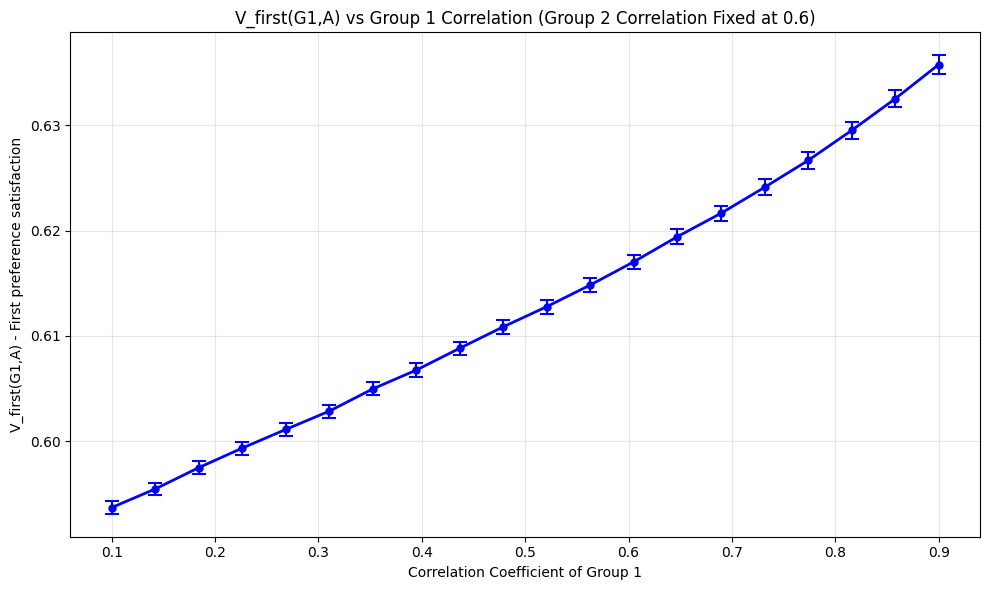

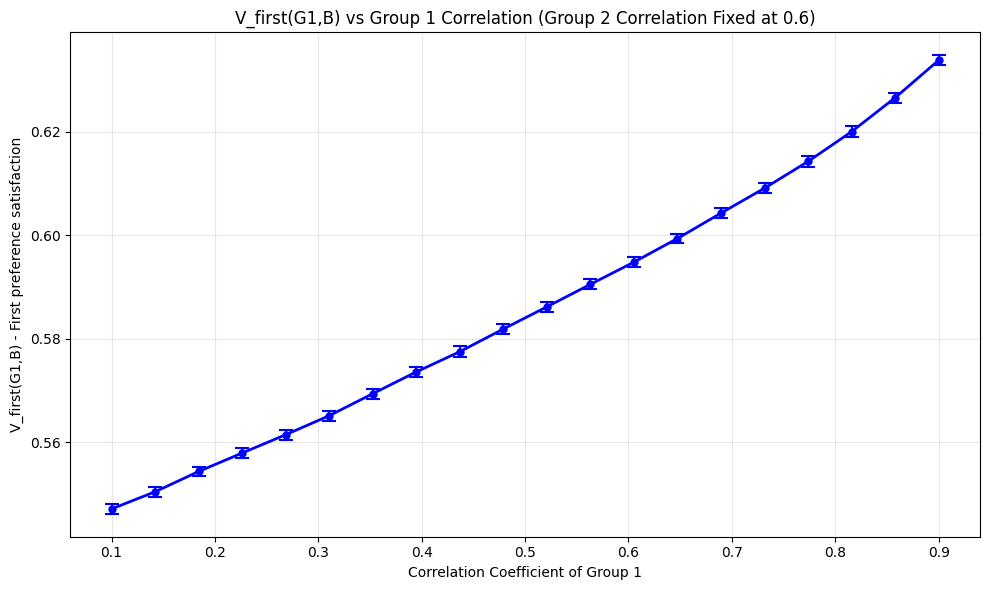

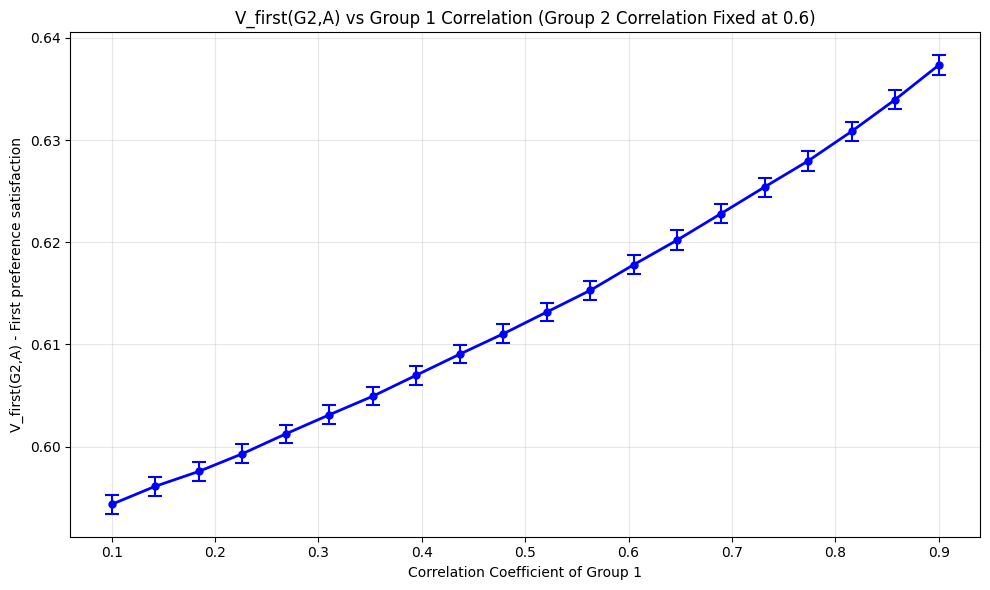

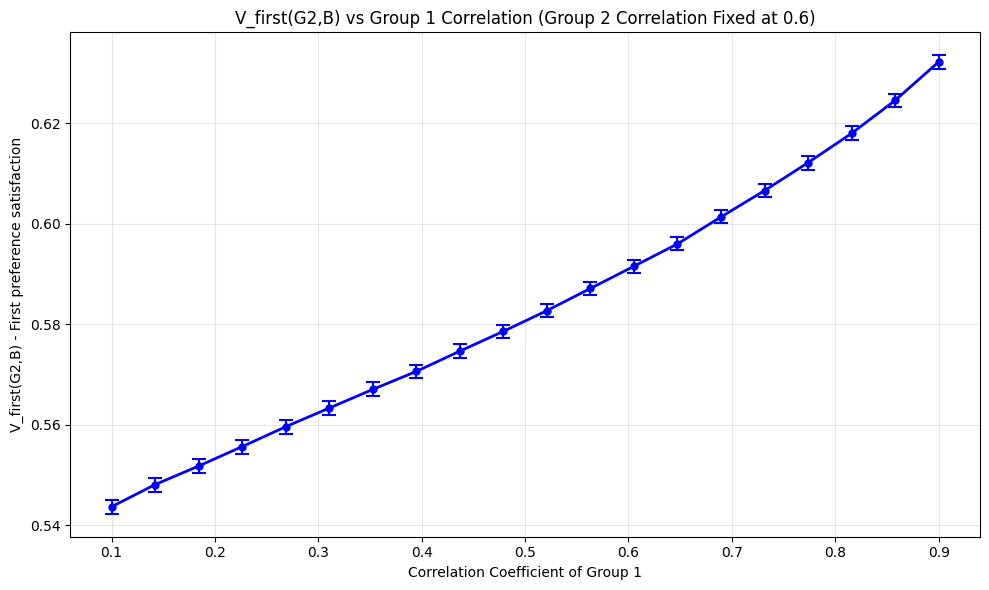

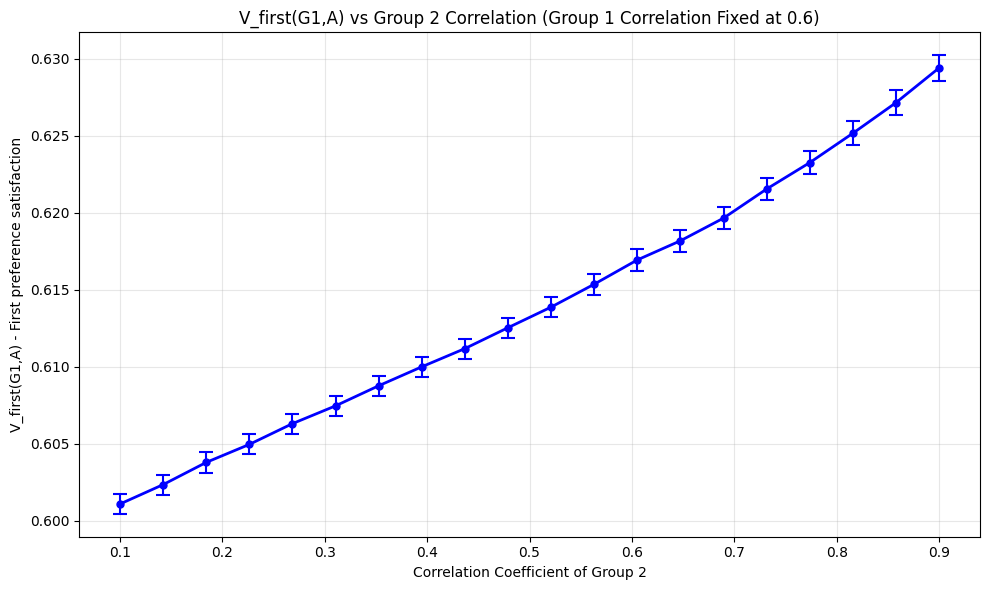

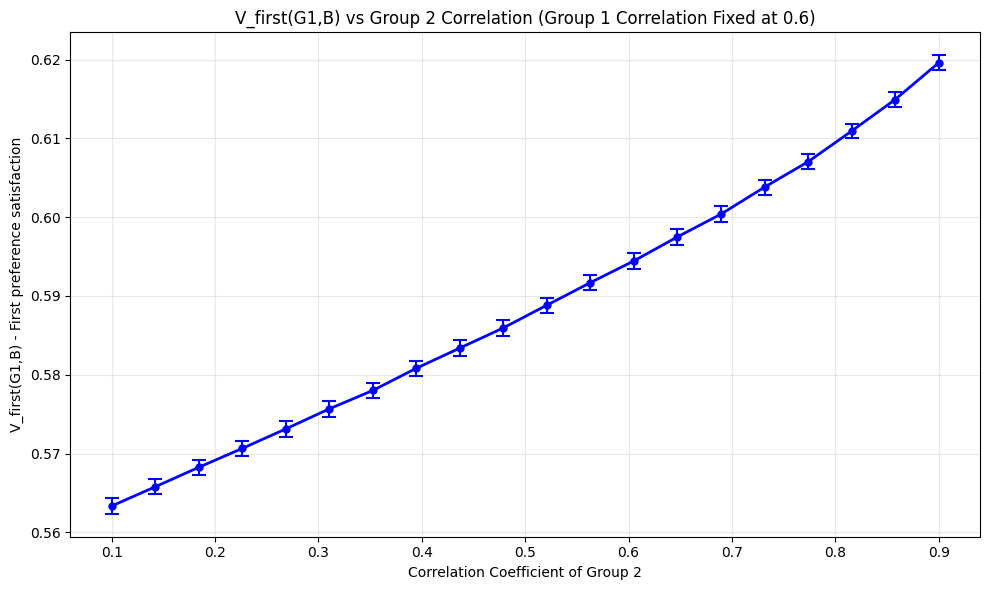

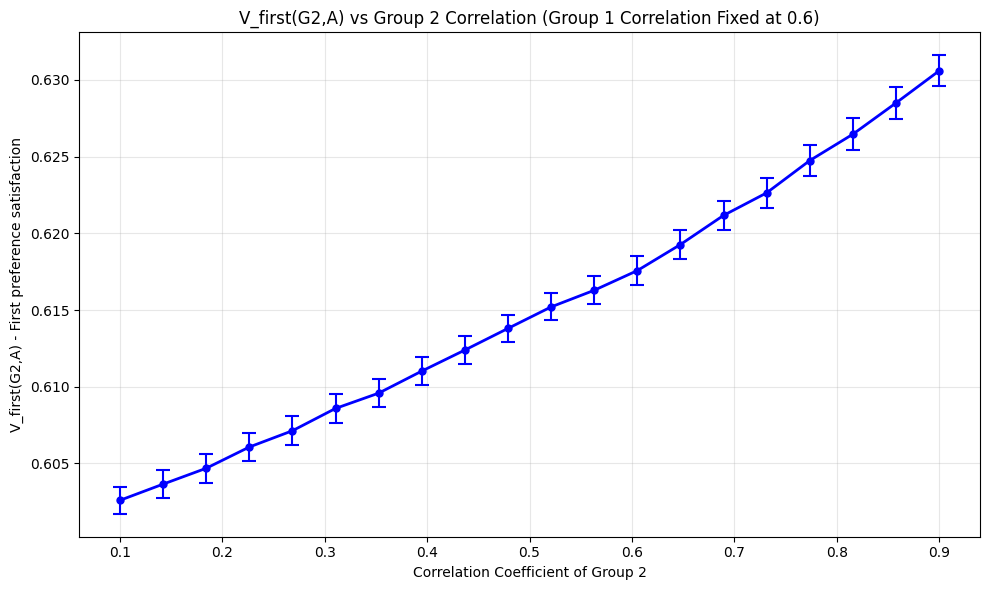

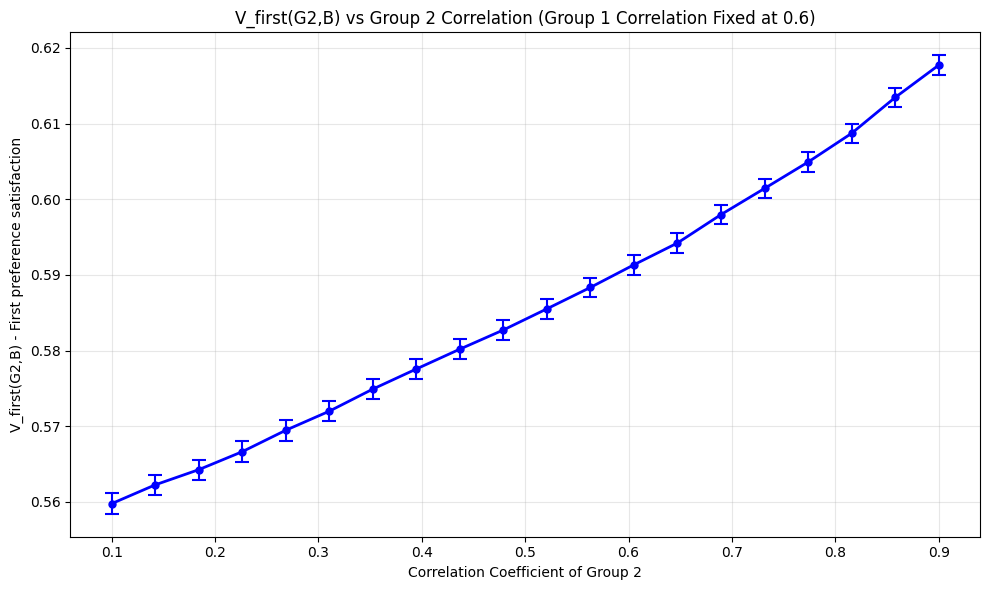

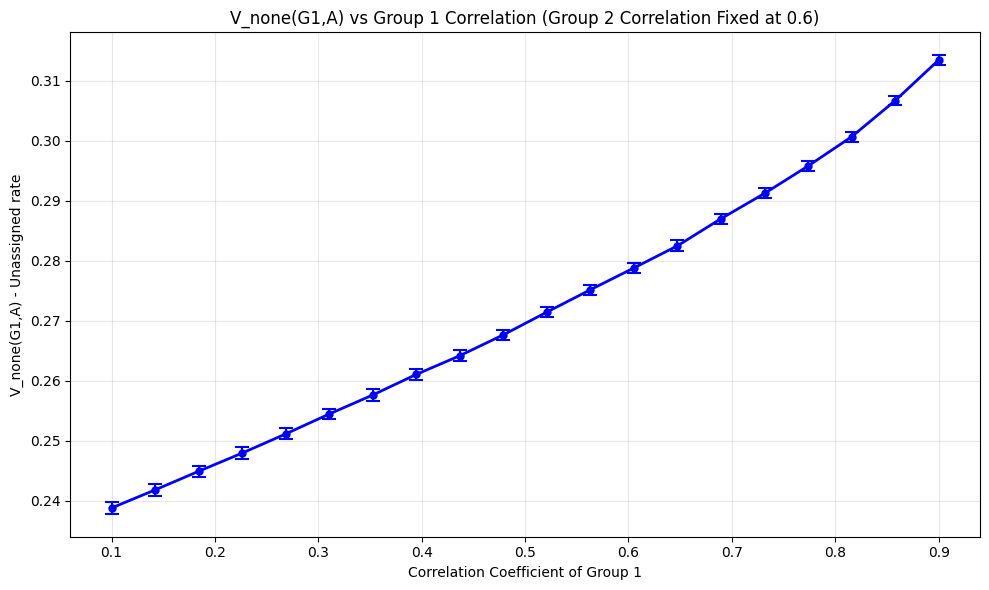

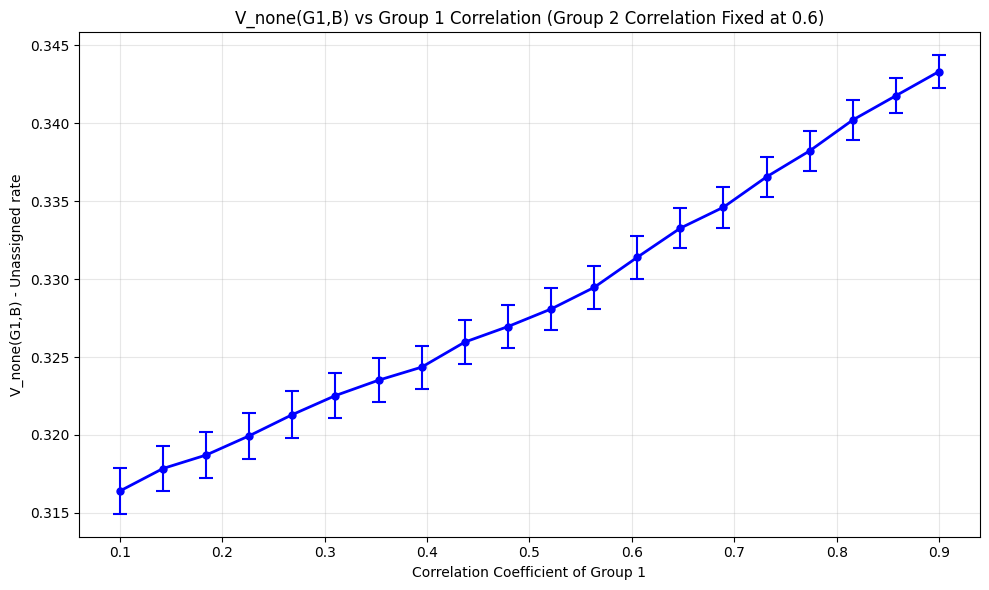

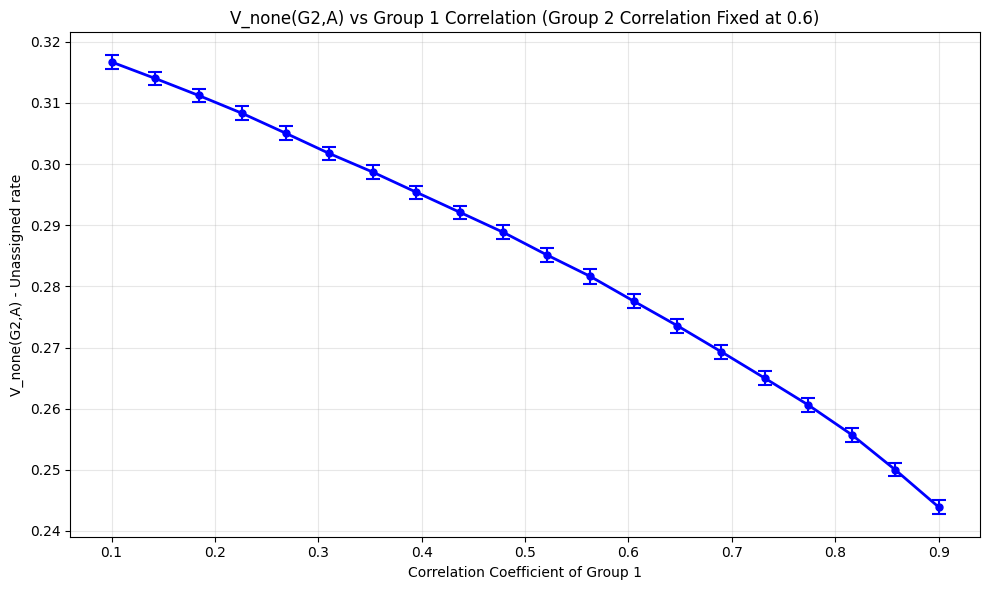

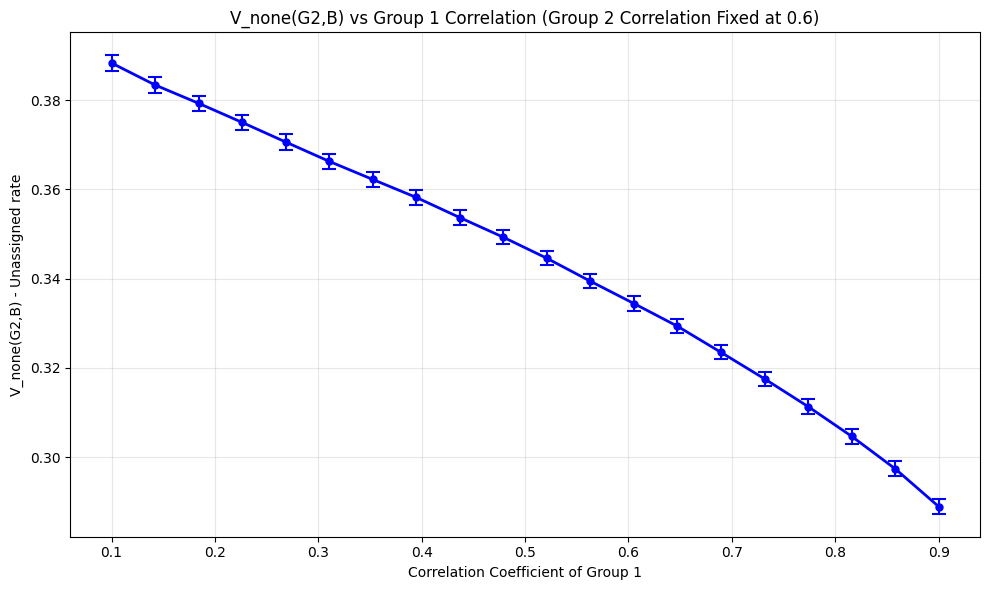

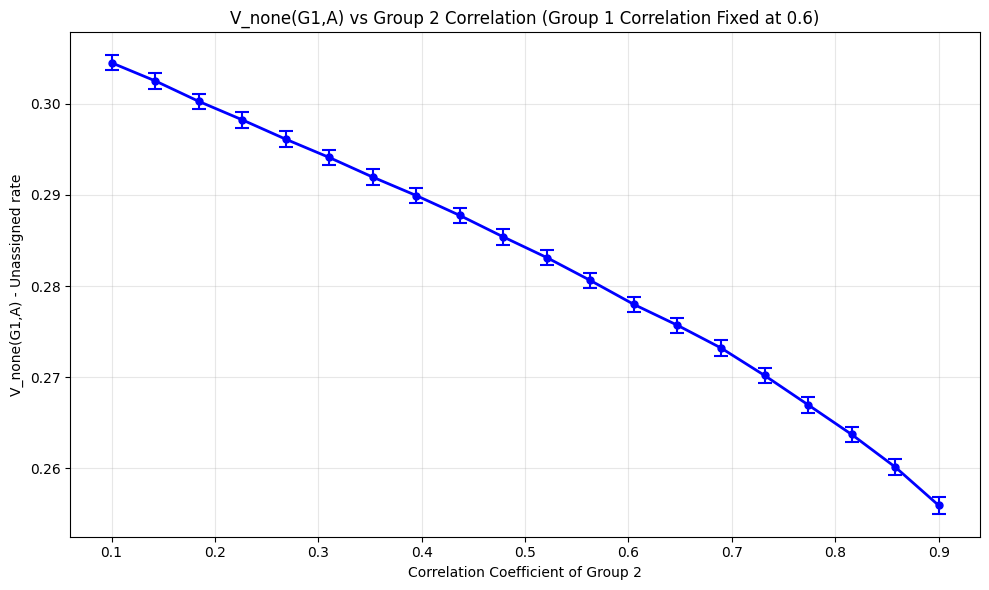

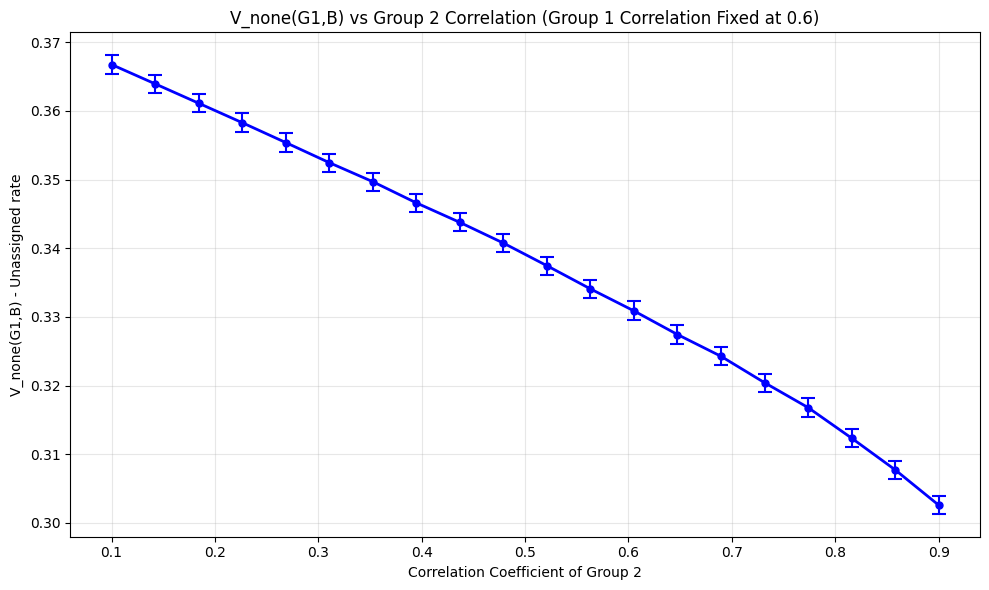

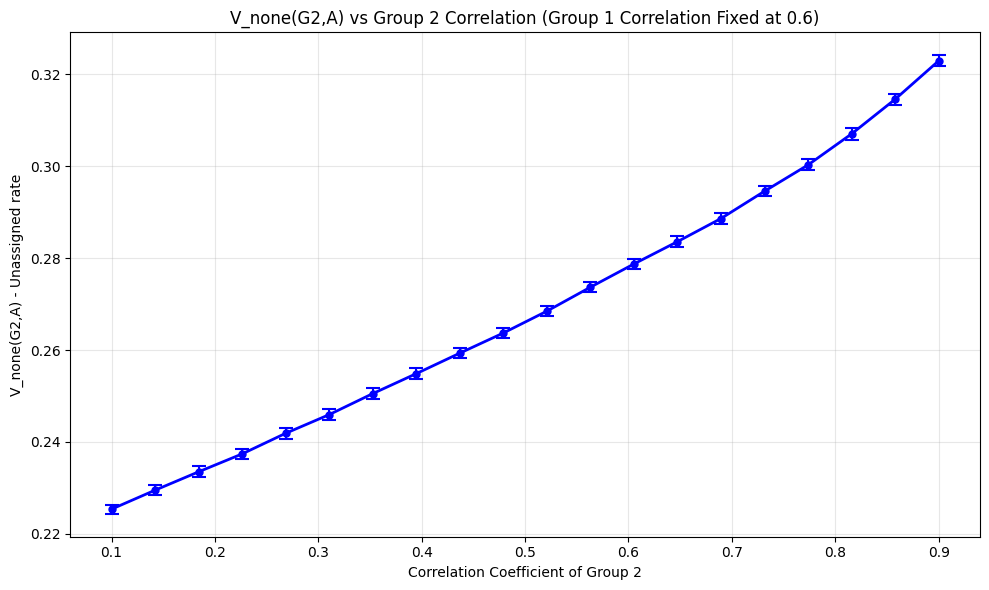

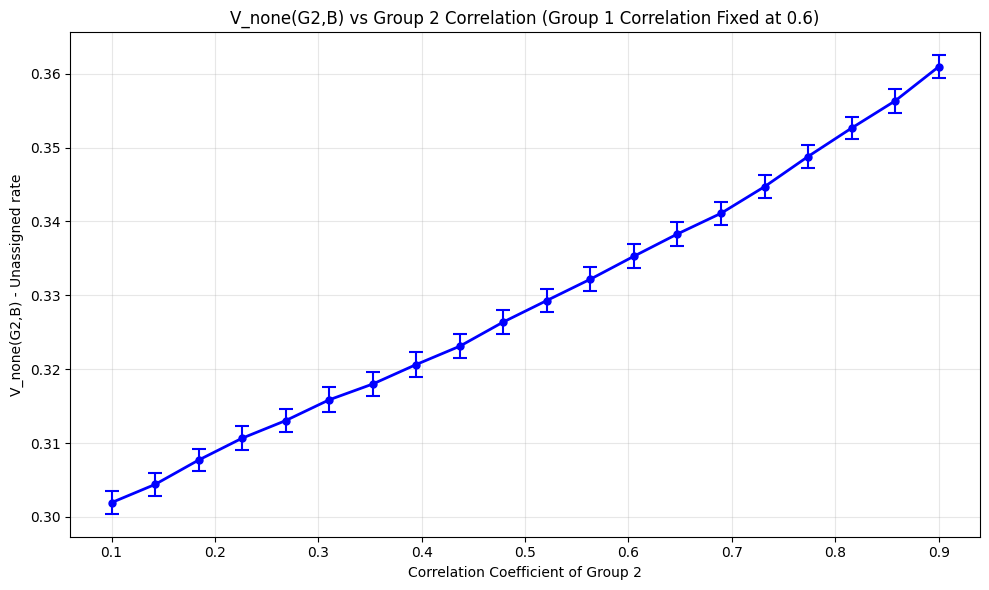

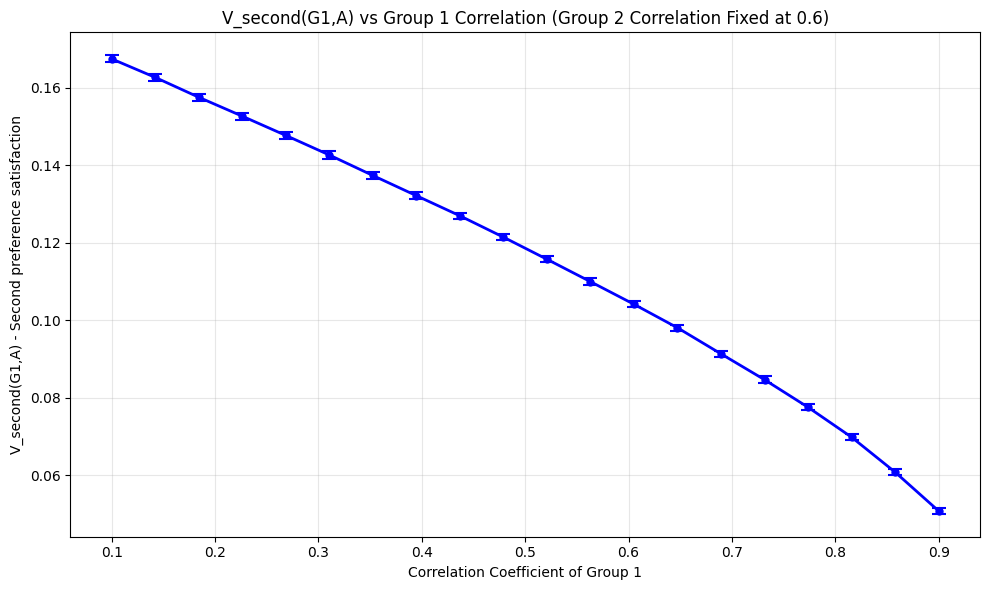

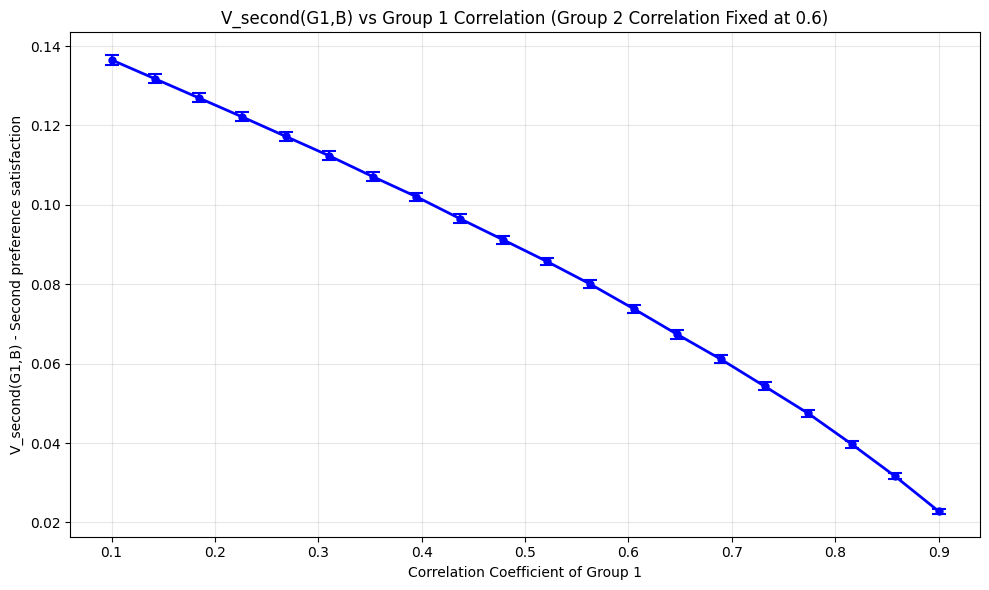

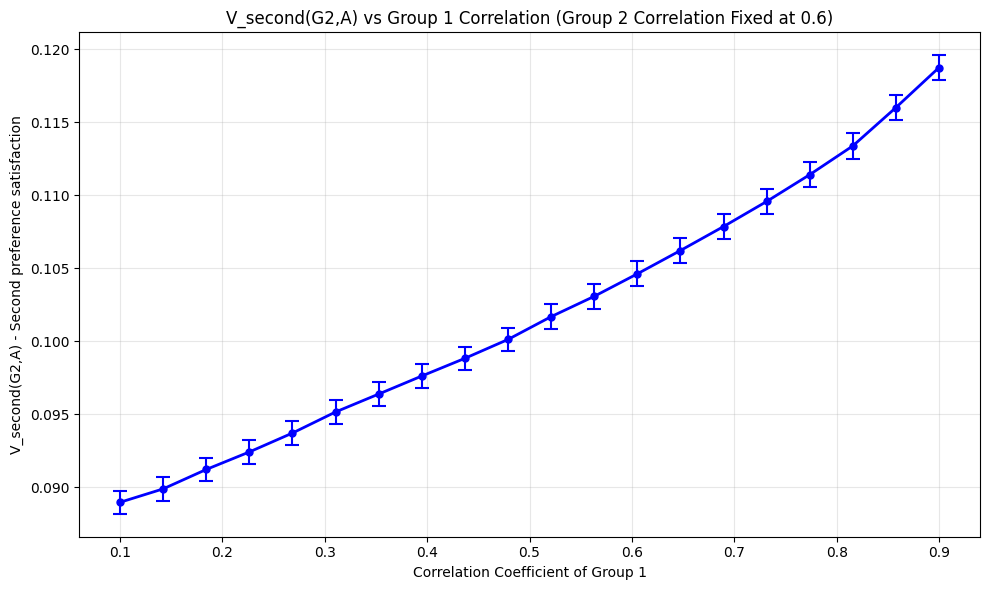

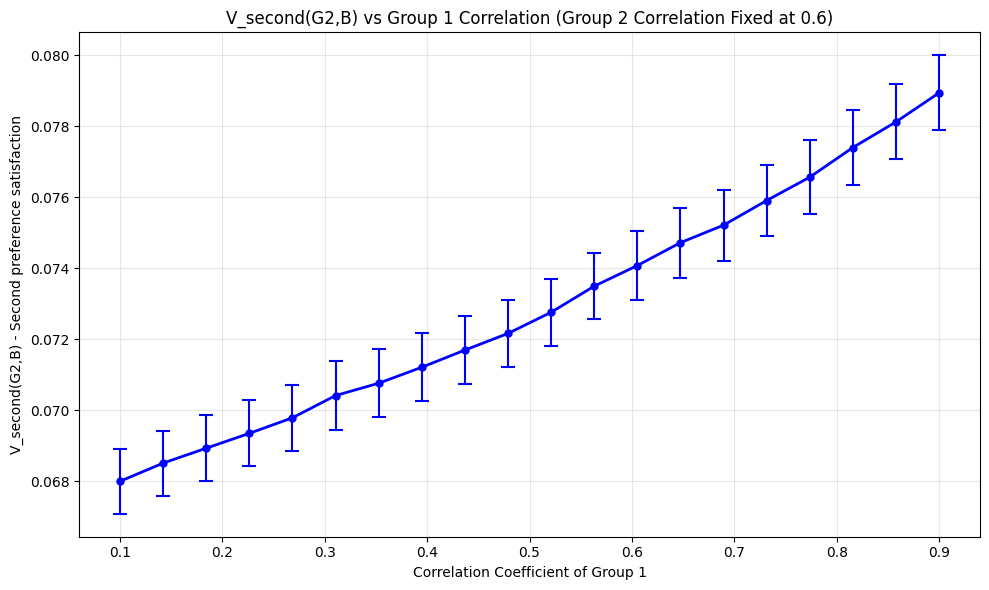

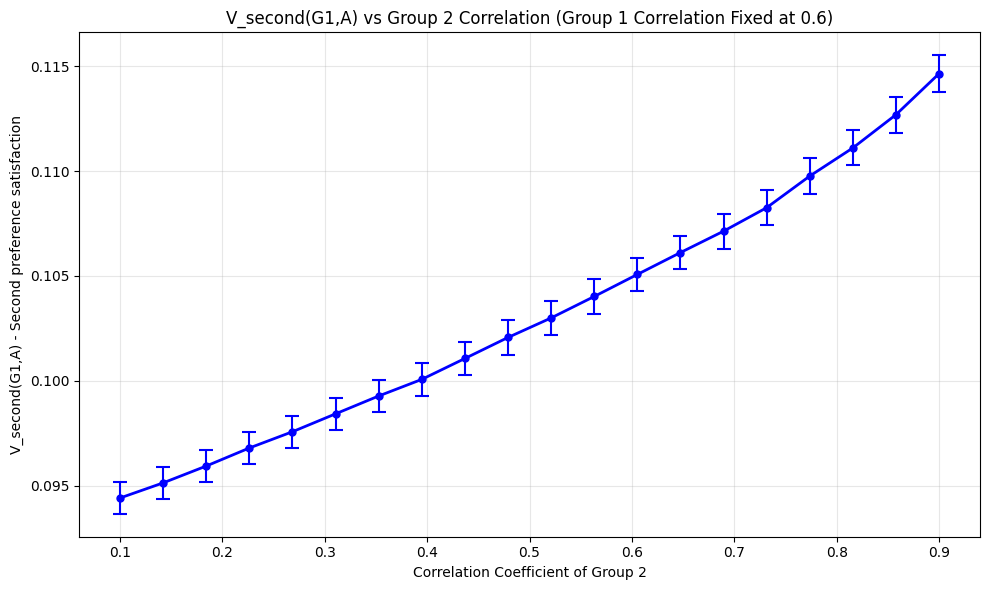

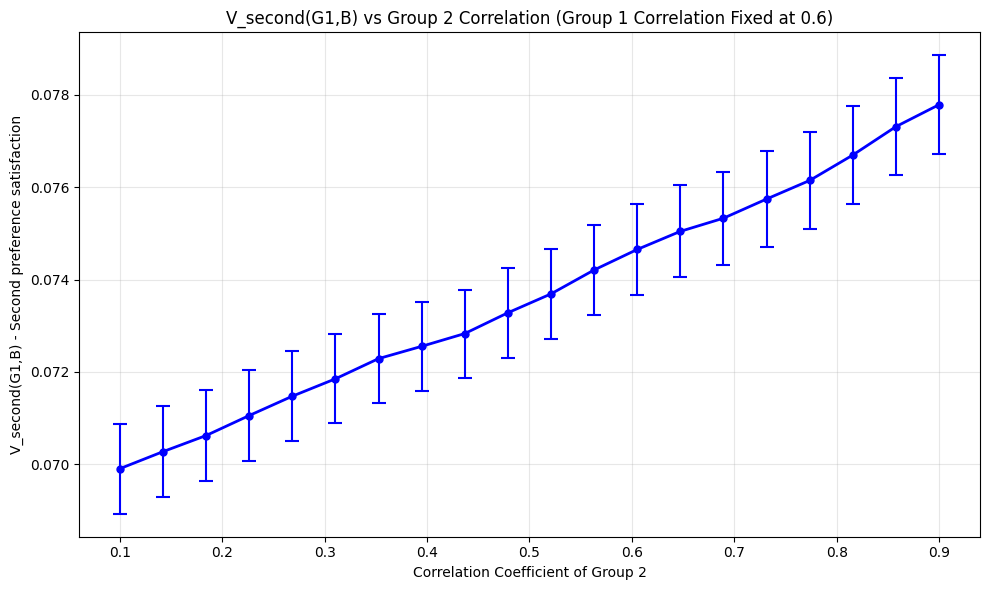

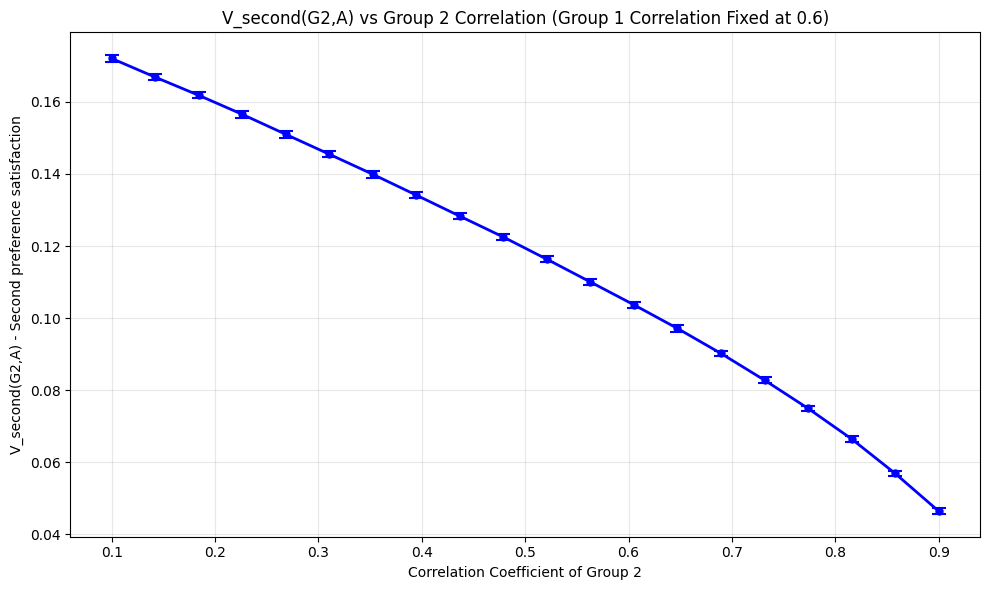

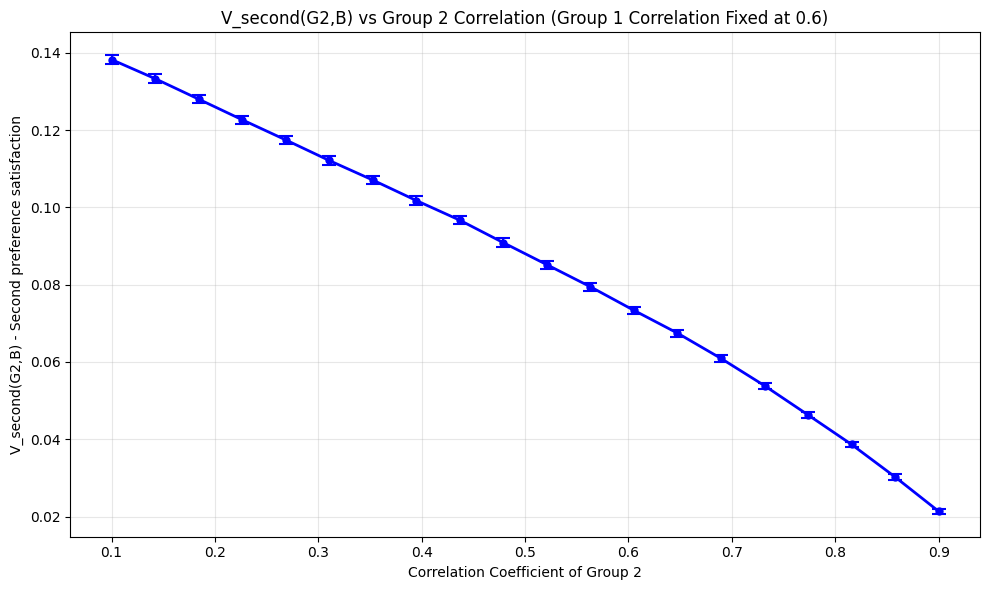

All individual line graphs with error bars have been generated, saved with unique filenames, and displayed in the notebook.


In [ ]:
# Create individual line graphs with error bars for all metrics

# Helper function to plot line graphs with error bars
def plot_with_error_bars(x, y, yerr, xlabel, ylabel, title, filename):
    plt.figure(figsize=(10, 6))

    # Plot the mean line in blue
    plt.plot(x, y, '-', color='blue', linewidth=2, marker='o', markersize=5)

    # Add error bars in blue
    plt.errorbar(x, y, yerr=yerr, fmt='none', ecolor='blue', elinewidth=1.5, capsize=5, capthick=1.5)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    plt.close()

# =========== V_first metrics vs Group 1 correlation (when Group 2 correlation is fixed) ===========
plot_with_error_bars(
    results_fixed_g2['CORRELATION_GROUP1'], results_fixed_g2['V_first(G1,A)_mean'],
    results_fixed_g2['V_first(G1,A)_se'], 'Correlation Coefficient of Group 1',
    'V_first(G1,A) - First preference satisfaction',
    f'V_first(G1,A) vs Group 1 Correlation (Group 2 Correlation Fixed at {FIXED_CORRELATION_G2})',
    'V_first_G1A_vs_G1_correlation.png'
)

plot_with_error_bars(
    results_fixed_g2['CORRELATION_GROUP1'], results_fixed_g2['V_first(G1,B)_mean'],
    results_fixed_g2['V_first(G1,B)_se'], 'Correlation Coefficient of Group 1',
    'V_first(G1,B) - First preference satisfaction',
    f'V_first(G1,B) vs Group 1 Correlation (Group 2 Correlation Fixed at {FIXED_CORRELATION_G2})',
    'V_first_G1B_vs_G1_correlation.png'
)

plot_with_error_bars(
    results_fixed_g2['CORRELATION_GROUP1'], results_fixed_g2['V_first(G2,A)_mean'],
    results_fixed_g2['V_first(G2,A)_se'], 'Correlation Coefficient of Group 1',
    'V_first(G2,A) - First preference satisfaction',
    f'V_first(G2,A) vs Group 1 Correlation (Group 2 Correlation Fixed at {FIXED_CORRELATION_G2})',
    'V_first_G2A_vs_G1_correlation.png'
)

plot_with_error_bars(
    results_fixed_g2['CORRELATION_GROUP1'], results_fixed_g2['V_first(G2,B)_mean'],
    results_fixed_g2['V_first(G2,B)_se'], 'Correlation Coefficient of Group 1',
    'V_first(G2,B) - First preference satisfaction',
    f'V_first(G2,B) vs Group 1 Correlation (Group 2 Correlation Fixed at {FIXED_CORRELATION_G2})',
    'V_first_G2B_vs_G1_correlation.png'
)

# =========== V_first metrics vs Group 2 correlation (when Group 1 correlation is fixed) ===========
plot_with_error_bars(
    results_fixed_g1['CORRELATION_GROUP2'], results_fixed_g1['V_first(G1,A)_mean'],
    results_fixed_g1['V_first(G1,A)_se'], 'Correlation Coefficient of Group 2',
    'V_first(G1,A) - First preference satisfaction',
    f'V_first(G1,A) vs Group 2 Correlation (Group 1 Correlation Fixed at {FIXED_CORRELATION_G1})',
    'V_first_G1A_vs_G2_correlation.png'
)

plot_with_error_bars(
    results_fixed_g1['CORRELATION_GROUP2'], results_fixed_g1['V_first(G1,B)_mean'],
    results_fixed_g1['V_first(G1,B)_se'], 'Correlation Coefficient of Group 2',
    'V_first(G1,B) - First preference satisfaction',
    f'V_first(G1,B) vs Group 2 Correlation (Group 1 Correlation Fixed at {FIXED_CORRELATION_G1})',
    'V_first_G1B_vs_G2_correlation.png'
)

plot_with_error_bars(
    results_fixed_g1['CORRELATION_GROUP2'], results_fixed_g1['V_first(G2,A)_mean'],
    results_fixed_g1['V_first(G2,A)_se'], 'Correlation Coefficient of Group 2',
    'V_first(G2,A) - First preference satisfaction',
    f'V_first(G2,A) vs Group 2 Correlation (Group 1 Correlation Fixed at {FIXED_CORRELATION_G1})',
    'V_first_G2A_vs_G2_correlation.png'
)

plot_with_error_bars(
    results_fixed_g1['CORRELATION_GROUP2'], results_fixed_g1['V_first(G2,B)_mean'],
    results_fixed_g1['V_first(G2,B)_se'], 'Correlation Coefficient of Group 2',
    'V_first(G2,B) - First preference satisfaction',
    f'V_first(G2,B) vs Group 2 Correlation (Group 1 Correlation Fixed at {FIXED_CORRELATION_G1})',
    'V_first_G2B_vs_G2_correlation.png'
)

# =========== V_none metrics vs Group 1 correlation (when Group 2 correlation is fixed) ===========
plot_with_error_bars(
    results_fixed_g2['CORRELATION_GROUP1'], results_fixed_g2['V_none(G1,A)_mean'],
    results_fixed_g2['V_none(G1,A)_se'], 'Correlation Coefficient of Group 1',
    'V_none(G1,A) - Unassigned rate',
    f'V_none(G1,A) vs Group 1 Correlation (Group 2 Correlation Fixed at {FIXED_CORRELATION_G2})',
    'V_none_G1A_vs_G1_correlation.png'
)

plot_with_error_bars(
    results_fixed_g2['CORRELATION_GROUP1'], results_fixed_g2['V_none(G1,B)_mean'],
    results_fixed_g2['V_none(G1,B)_se'], 'Correlation Coefficient of Group 1',
    'V_none(G1,B) - Unassigned rate',
    f'V_none(G1,B) vs Group 1 Correlation (Group 2 Correlation Fixed at {FIXED_CORRELATION_G2})',
    'V_none_G1B_vs_G1_correlation.png'
)

plot_with_error_bars(
    results_fixed_g2['CORRELATION_GROUP1'], results_fixed_g2['V_none(G2,A)_mean'],
    results_fixed_g2['V_none(G2,A)_se'], 'Correlation Coefficient of Group 1',
    'V_none(G2,A) - Unassigned rate',
    f'V_none(G2,A) vs Group 1 Correlation (Group 2 Correlation Fixed at {FIXED_CORRELATION_G2})',
    'V_none_G2A_vs_G1_correlation.png'
)

plot_with_error_bars(
    results_fixed_g2['CORRELATION_GROUP1'], results_fixed_g2['V_none(G2,B)_mean'],
    results_fixed_g2['V_none(G2,B)_se'], 'Correlation Coefficient of Group 1',
    'V_none(G2,B) - Unassigned rate',
    f'V_none(G2,B) vs Group 1 Correlation (Group 2 Correlation Fixed at {FIXED_CORRELATION_G2})',
    'V_none_G2B_vs_G1_correlation.png'
)

# =========== V_none metrics vs Group 2 correlation (when Group 1 correlation is fixed) ===========
plot_with_error_bars(
    results_fixed_g1['CORRELATION_GROUP2'], results_fixed_g1['V_none(G1,A)_mean'],
    results_fixed_g1['V_none(G1,A)_se'], 'Correlation Coefficient of Group 2',
    'V_none(G1,A) - Unassigned rate',
    f'V_none(G1,A) vs Group 2 Correlation (Group 1 Correlation Fixed at {FIXED_CORRELATION_G1})',
    'V_none_G1A_vs_G2_correlation.png'
)

plot_with_error_bars(
    results_fixed_g1['CORRELATION_GROUP2'], results_fixed_g1['V_none(G1,B)_mean'],
    results_fixed_g1['V_none(G1,B)_se'], 'Correlation Coefficient of Group 2',
    'V_none(G1,B) - Unassigned rate',
    f'V_none(G1,B) vs Group 2 Correlation (Group 1 Correlation Fixed at {FIXED_CORRELATION_G1})',
    'V_none_G1B_vs_G2_correlation.png'
)

plot_with_error_bars(
    results_fixed_g1['CORRELATION_GROUP2'], results_fixed_g1['V_none(G2,A)_mean'],
    results_fixed_g1['V_none(G2,A)_se'], 'Correlation Coefficient of Group 2',
    'V_none(G2,A) - Unassigned rate',
    f'V_none(G2,A) vs Group 2 Correlation (Group 1 Correlation Fixed at {FIXED_CORRELATION_G1})',
    'V_none_G2A_vs_G2_correlation.png'
)

plot_with_error_bars(
    results_fixed_g1['CORRELATION_GROUP2'], results_fixed_g1['V_none(G2,B)_mean'],
    results_fixed_g1['V_none(G2,B)_se'], 'Correlation Coefficient of Group 2',
    'V_none(G2,B) - Unassigned rate',
    f'V_none(G2,B) vs Group 2 Correlation (Group 1 Correlation Fixed at {FIXED_CORRELATION_G1})',
    'V_none_G2B_vs_G2_correlation.png'
)

# =========== V_second metrics vs Group 1 correlation (when Group 2 correlation is fixed) ===========
plot_with_error_bars(
    results_fixed_g2['CORRELATION_GROUP1'], results_fixed_g2['V_second(G1,A)_mean'],
    results_fixed_g2['V_second(G1,A)_se'], 'Correlation Coefficient of Group 1',
    'V_second(G1,A) - Second preference satisfaction',
    f'V_second(G1,A) vs Group 1 Correlation (Group 2 Correlation Fixed at {FIXED_CORRELATION_G2})',
    'V_second_G1A_vs_G1_correlation.png'
)

plot_with_error_bars(
    results_fixed_g2['CORRELATION_GROUP1'], results_fixed_g2['V_second(G1,B)_mean'],
    results_fixed_g2['V_second(G1,B)_se'], 'Correlation Coefficient of Group 1',
    'V_second(G1,B) - Second preference satisfaction',
    f'V_second(G1,B) vs Group 1 Correlation (Group 2 Correlation Fixed at {FIXED_CORRELATION_G2})',
    'V_second_G1B_vs_G1_correlation.png'
)

plot_with_error_bars(
    results_fixed_g2['CORRELATION_GROUP1'], results_fixed_g2['V_second(G2,A)_mean'],
    results_fixed_g2['V_second(G2,A)_se'], 'Correlation Coefficient of Group 1',
    'V_second(G2,A) - Second preference satisfaction',
    f'V_second(G2,A) vs Group 1 Correlation (Group 2 Correlation Fixed at {FIXED_CORRELATION_G2})',
    'V_second_G2A_vs_G1_correlation.png'
)

plot_with_error_bars(
    results_fixed_g2['CORRELATION_GROUP1'], results_fixed_g2['V_second(G2,B)_mean'],
    results_fixed_g2['V_second(G2,B)_se'], 'Correlation Coefficient of Group 1',
    'V_second(G2,B) - Second preference satisfaction',
    f'V_second(G2,B) vs Group 1 Correlation (Group 2 Correlation Fixed at {FIXED_CORRELATION_G2})',
    'V_second_G2B_vs_G1_correlation.png'
)

# =========== V_second metrics vs Group 2 correlation (when Group 1 correlation is fixed) ===========
plot_with_error_bars(
    results_fixed_g1['CORRELATION_GROUP2'], results_fixed_g1['V_second(G1,A)_mean'],
    results_fixed_g1['V_second(G1,A)_se'], 'Correlation Coefficient of Group 2',
    'V_second(G1,A) - Second preference satisfaction',
    f'V_second(G1,A) vs Group 2 Correlation (Group 1 Correlation Fixed at {FIXED_CORRELATION_G1})',
    'V_second_G1A_vs_G2_correlation.png'
)

plot_with_error_bars(
    results_fixed_g1['CORRELATION_GROUP2'], results_fixed_g1['V_second(G1,B)_mean'],
    results_fixed_g1['V_second(G1,B)_se'], 'Correlation Coefficient of Group 2',
    'V_second(G1,B) - Second preference satisfaction',
    f'V_second(G1,B) vs Group 2 Correlation (Group 1 Correlation Fixed at {FIXED_CORRELATION_G1})',
    'V_second_G1B_vs_G2_correlation.png'
)

plot_with_error_bars(
    results_fixed_g1['CORRELATION_GROUP2'], results_fixed_g1['V_second(G2,A)_mean'],
    results_fixed_g1['V_second(G2,A)_se'], 'Correlation Coefficient of Group 2',
    'V_second(G2,A) - Second preference satisfaction',
    f'V_second(G2,A) vs Group 2 Correlation (Group 1 Correlation Fixed at {FIXED_CORRELATION_G1})',
    'V_second_G2A_vs_G2_correlation.png'
)

plot_with_error_bars(
    results_fixed_g1['CORRELATION_GROUP2'], results_fixed_g1['V_second(G2,B)_mean'],
    results_fixed_g1['V_second(G2,B)_se'], 'Correlation Coefficient of Group 2',
    'V_second(G2,B) - Second preference satisfaction',
    f'V_second(G2,B) vs Group 2 Correlation (Group 1 Correlation Fixed at {FIXED_CORRELATION_G1})',
    'V_second_G2B_vs_G2_correlation.png'
)

print("All individual line graphs with error bars have been generated, saved with unique filenames, and displayed in the notebook.")

In [ ]:
# Save experiment results to CSV files for further analysis
results_fixed_g1.to_csv('correlation_experiment_fixed_g1.csv', index=False)
results_fixed_g2.to_csv('correlation_experiment_fixed_g2.csv', index=False)

print("Experiment results saved to CSV files.")
print("All plots have been generated and saved.")

Experiment results saved to CSV files.
All plots have been generated and saved.
